In [1]:
# CBF imports
import scipy
import numpy as np
import matplotlib.patches as pat
import matplotlib.pyplot  as plt
from data      import make_rectangle, insert_shape, plot_data, plot_angle_data
from agent     import Agent
from controls  import hjb_controls, hjb_controls_parallel
from tst_optim import get_learning_cbfs_lagrangian_hj, get_h, get_learning_cbfs_lagrangian_hj_optim, cvx_train_cbf, clarabel_solve_cbf
from utils     import plot_cbf, plot_angles, quad_plot

# HJB imports 
import jax
import jax.numpy as jnp
from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import hj_reachability as hj

%load_ext autoreload
%autoreload 2

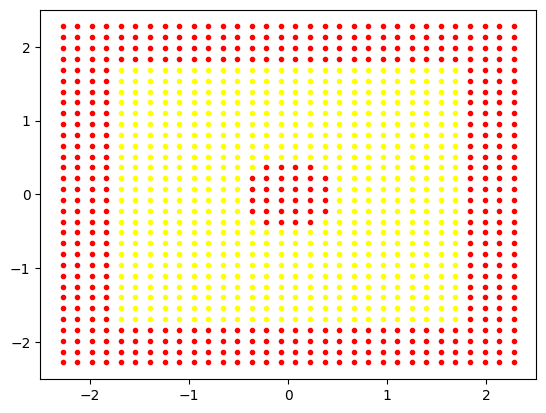

spacing: 0.14677419354838708


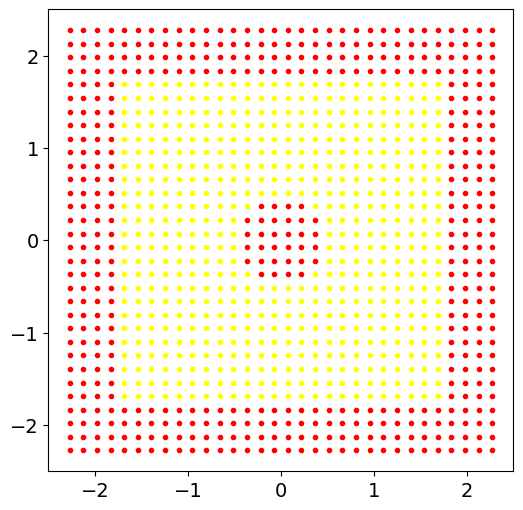

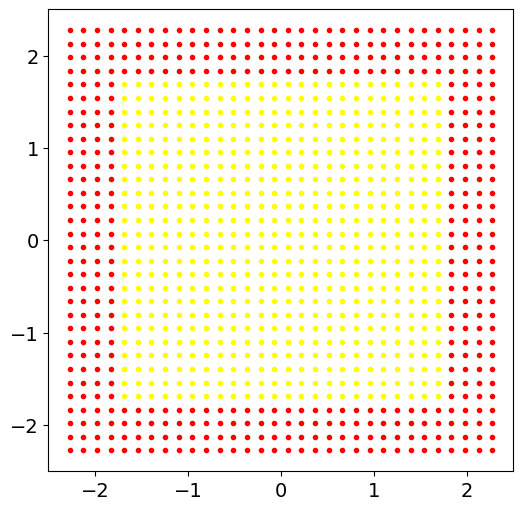

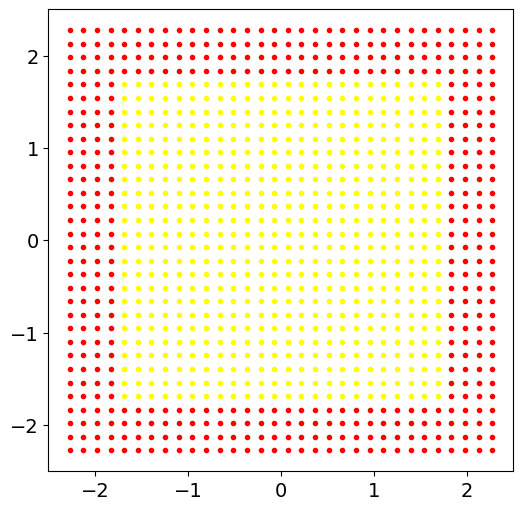

In [2]:
#########################
### Data Construction ###
#########################

width         = 3.5
density       = 50
unsafe_margin = 0.3
thn           = 20

# make grid and obstacles
obs_funcs = []
grid, params, obs_dict, is_obs_grid = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
#obs_dict = insert_shape(np.array([0,  1.5]), grid, obs_dict, shape='circle', scale=0.75, theta=0)
obs_dict, is_obs_circ = insert_shape(np.array([0, 0]), grid, obs_dict, shape='circle', scale=0.50, theta=0)
obs_funcs.append(is_obs_grid)
obs_funcs.append(is_obs_circ)

from data import check_obs
for pt in grid:
    if check_obs(pt, obs_funcs):
        plt.plot(pt[0], pt[1], marker='.', color="r", linestyle="none")
    else:
        plt.plot(pt[0], pt[1], marker='.', color="yellow", linestyle="none")
plt.show()

# grids for centers and unsafe samples
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))


# initialize hjb grid
lo, hi, n, spacing = params
print("spacing:", spacing)
lo = lo + (0       ,)
hi = hi + (2*jnp.pi,)
n  = n  + (thn     ,)

hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n, periodic_dims=2)

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(1024, 2)
(32, 32, 20)


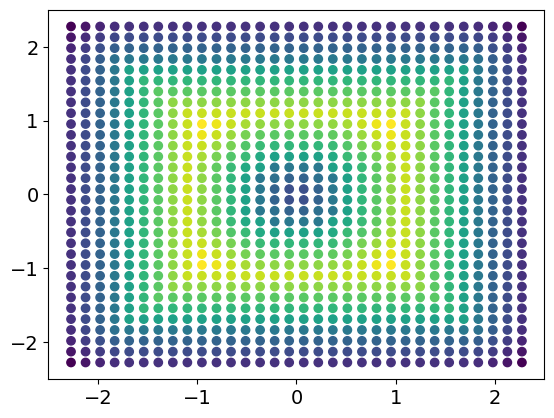

In [3]:
#####################################
### Make Signed Distance Function ###
#####################################

l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])
fre_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] == 0])

for i in range(n[0]):
    for j in range(n[1]):
        for k in range(n[2]):
            if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j, k, :-1]), 3))] != 0:
                l[i, j, k] = -np.min(np.linalg.norm(fre_coords - hjb_grid.states[i, j, k, :2], axis=1))
            else:
                l[i, j, k] =  np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j, k, :2], axis=1))

print(grid.shape)
print(l.shape)
plt.scatter(grid[:,0], grid[:,1], c=l[...,0].reshape(-1, 1))
plt.show()

In [4]:
############################
### Configure HJB Solver ###
############################

umax   = 0.50
utype  ="box"
V      = 0.10
l      = jnp.array(l)
values = l 
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [5]:
####################################
### Solver PDE for final surface ###
####################################

dynamics = hj.systems.Bicycle(V=V, umax=umax)
time = 0.
target_time = -500
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

100%|############################################################################################################################################| 500.0000/500.0 [00:02<00:00, 189.90sim_s/s]


<Figure size 640x480 with 0 Axes>

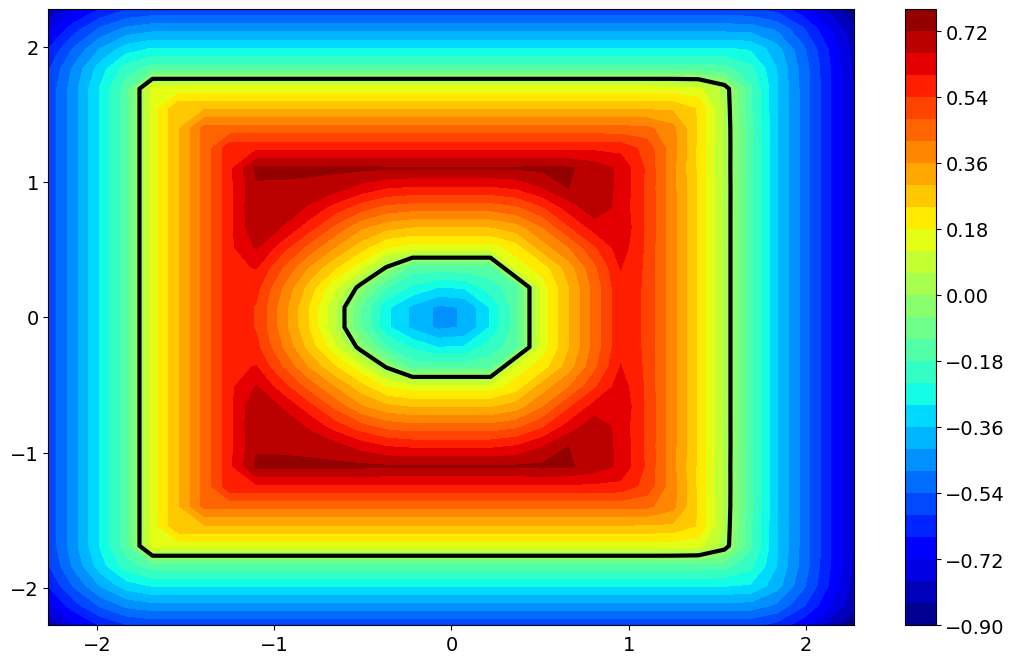

In [6]:
##########################
### Plot final surface ###
##########################

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :, 0].T, levels=30)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :, 0].T,
            levels=0,
            colors="black",
            linewidths=3)

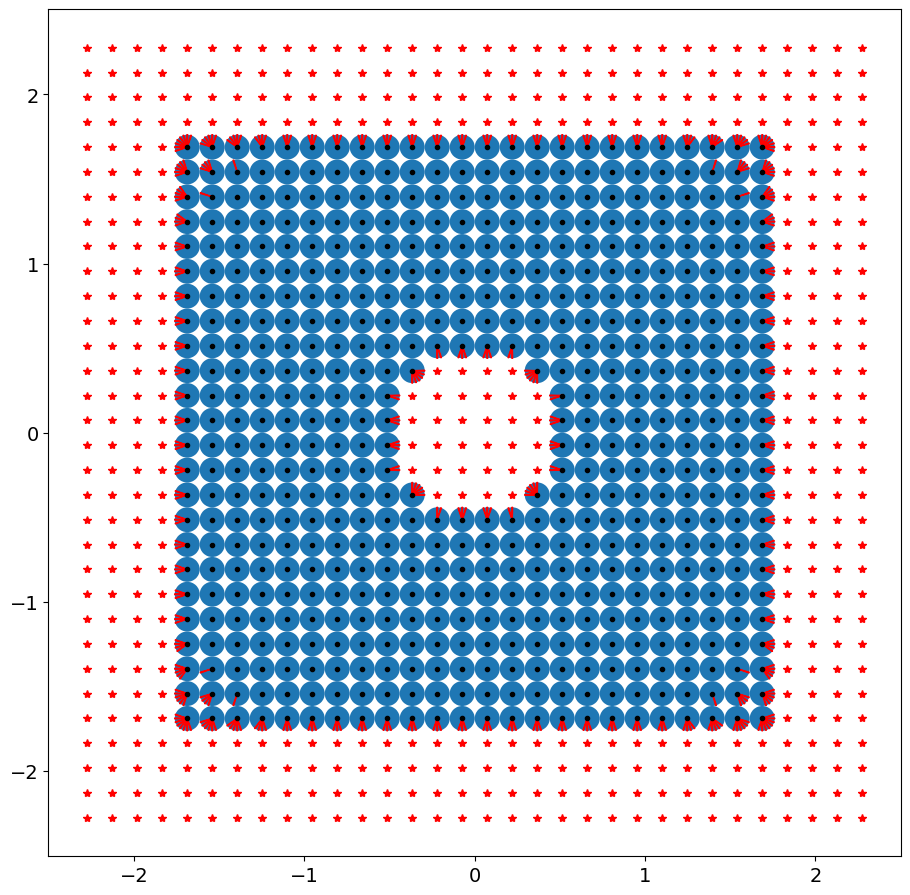

In [7]:
#######################################
### Plot V at each x,y using arrows ###
#######################################
ddegrees = 2

fig, ax = plt.subplots(figsize=(11,11))

plt.rc('xtick', labelsize=14)                                                
plt.rc('ytick', labelsize=14)                                                

for x in grid:                                                               
    if obs_dict[tuple(np.round(x, 3))] == 0:                               
        ax.plot(x[0], x[1], color="black", marker=".", linestyle="none")   
        A = pat.Annulus(x, spacing/2, spacing/2-0.01)
        ax.add_patch(A)
        pt = np.array([x[0], x[1], 0])
        idx = hjb_grid.nearest_index(pt)[:2]
        for i, Vtheta in enumerate(target_values[idx[0], idx[1]]):
            theta = hjb_grid.states[idx[0], idx[1], i][-1]
            if Vtheta <= 0:
                B = pat.Wedge(x, spacing/2, 360/(2*np.pi)*theta - ddegrees, 360/(2*np.pi)*theta + ddegrees, width=spacing/2, color='r')  
                ax.add_patch(B)
            #else:
            #    B = pat.Wedge(  x, s/2, 360/(2*np.pi)*theta - 1, 360/(2*np.pi)*theta + 1, width=s/2, color='b')  
            #    ax.add_patch(B)
    else:
        ax.plot(x[0], x[1], color="red"   , marker="*", linestyle="none") 

plt.show()

In [8]:
##############################
### Plot V(x, y, theta(t)) ###
##############################

vmin, vmax = target_values.min(), target_values.max()
levels = np.linspace(round(vmin), round(vmax), 5*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 target_values[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, target_values.shape[-1], interval=50).to_html5_video())
plt.close(); animation

In [9]:
##########################################
### Solve for backwards reachable tube ###
##########################################

times = np.linspace(0, -500, 100)
initial_values = l
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|############################################################################################################################################| 500.0000/500.0 [00:02<00:00, 175.21sim_s/s]


In [10]:
##########################################
### Visualize backwards reachable tube ###
##########################################

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), 15*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :, 10].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, 10].T,
                levels=0,
                colors="black",
                linewidths=3)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [11]:
###########################
### Agent Configuration ###
###########################

bf    = 31    # csrbf order
b     =-0.50  # offset
s     = 0.75  # csrbf zeroing
nm    = 0.20  # nm * n_safe = number of neighbors to consider
p     = 0.00  # num neighber percentile under which boundary
mult  = 1
utype = utype # defined w/ hjb above
umax  = umax  # defined w/ hjb above
solver        ='CLARABEL'
sensor_radius = 1.0
rx            = sensor_radius + 0.2 # sample radius
rc            = sensor_radius # radius around scan in which centers are chosen
init_x        =-1.1
init_y        =-1.1
init_theta    = 0

a = Agent(dynamics, np.array([init_x, init_y, init_theta]), grid, obs_dict, width         = width, 
                                                                            sensor_radius = sensor_radius,
                                                                            bf            = bf, 
                                                                            b             = b, 
                                                                            s             = s,
                                                                            umax          = umax,
                                                                            utype         = utype,
                                                                            solver        = solver,
                                                                            spacing       = spacing)

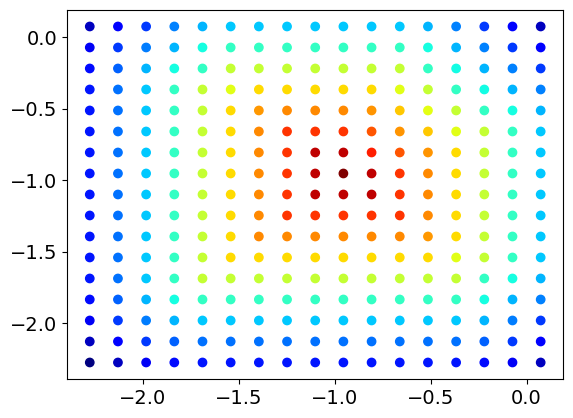

100%|############################################################################################################################################| 500.0000/500.0 [00:00<00:00, 606.82sim_s/s]


<Figure size 640x480 with 0 Axes>

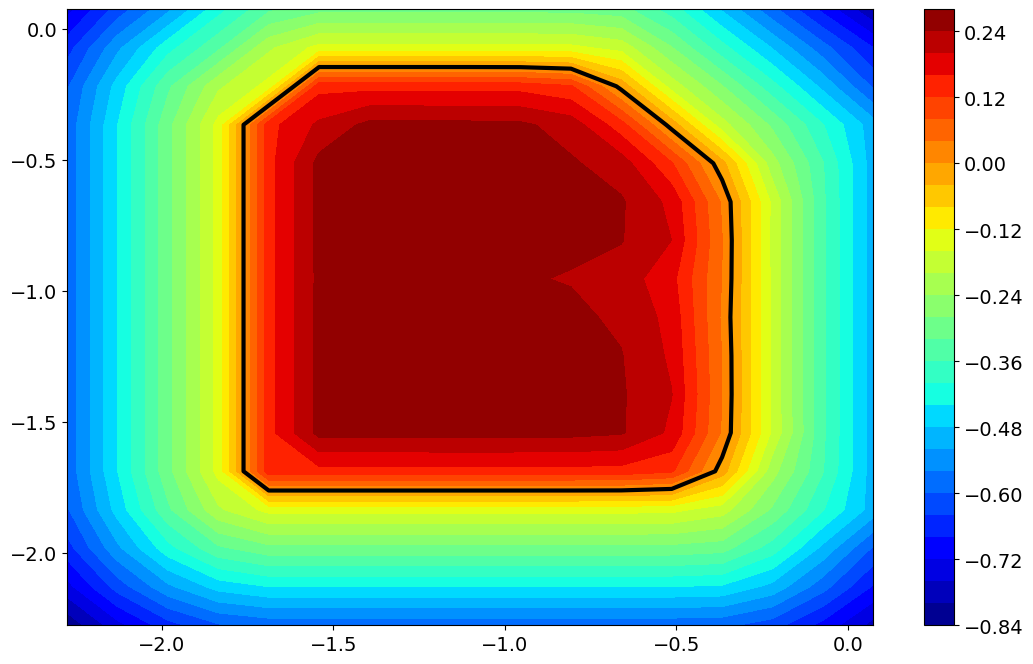

In [12]:
####################
### Initial scan ###
####################

# scan states 
pts_safe, pts_unsafe   = a.scan()
samples, gparams,\
         is_obs_sample = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True)
loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], pts_safe, np.vstack((pts_unsafe, samples[:,:2])), rx, thn, T=500, mult=mult)
scan_safe, scan_unsafe = a.scan_hjb(loc_V, loc_hjb_grid)
n_safe                 = len(pts_safe)
x_buffer, x_safe       = a.make_buffer(scan_safe, int(nm * n_safe), p, hjb=True)

# unsafe states 
if scan_unsafe.shape[0] != 0:
    x_unsafe = np.vstack((scan_unsafe, samples))
else: 
    x_unsafe = samples    

In [13]:
#######################
### Collect centers ###
#######################

C = []
for x in c_grid:
    if np.linalg.norm(x[:2] - a.pos[:2]) <= rc:
        C.append(x)
C = np.array(C)

tmp = []
for c in C:
    c = np.repeat(c.reshape(1, -1), hjb_grid.states.shape[2], axis=0)
    c = np.hstack((c, np.array(hjb_grid.coordinate_vectors[2]).reshape(-1, 1)))
    tmp.append(c)
C = np.vstack(tmp) 

a.centers.append(C)

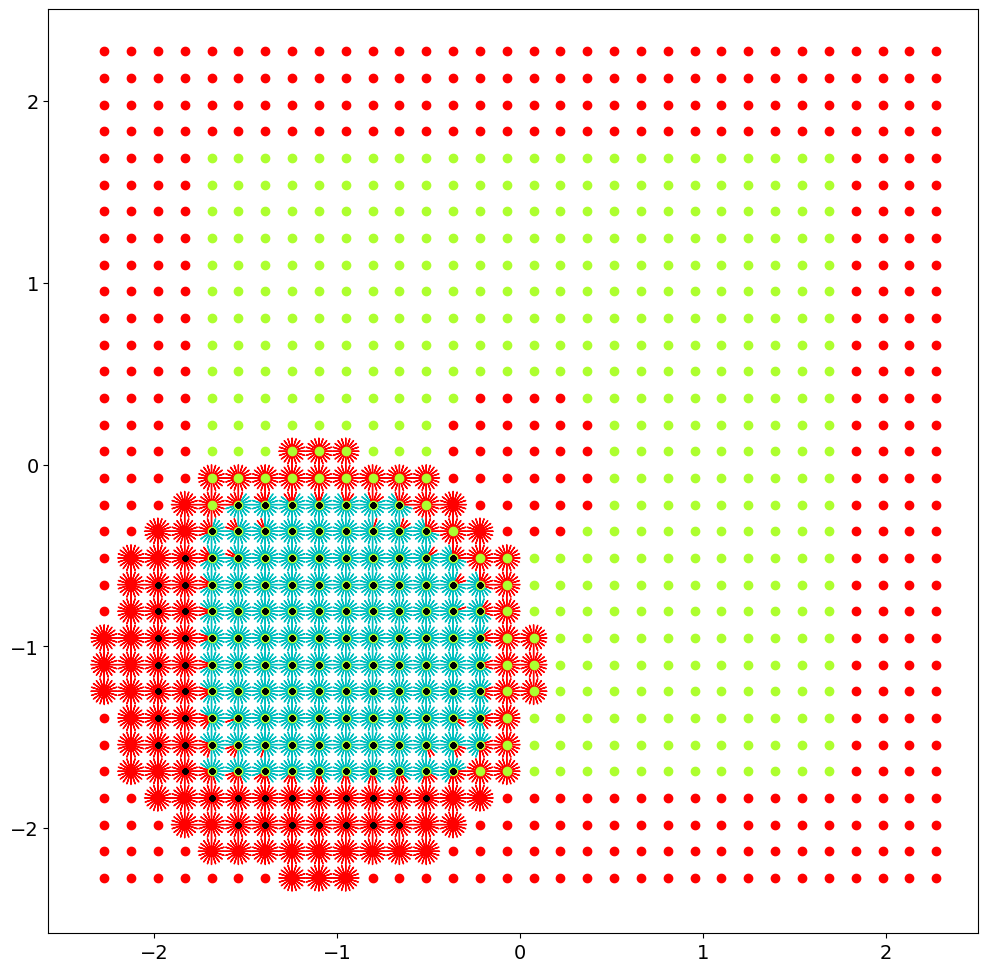

In [14]:
#############################
### Plot Initial CBF data ###
#############################

plot_angle_data(C, grid, obs_dict, spacing, safe=x_safe, buffer=x_buffer, unsafe=scan_unsafe, samples=samples)

In [15]:
###########################################
### Obtain controls from Value Function ###
###########################################

from tqdm import tqdm

u_safe = hjb_controls_parallel(a, x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    u_buffer = hjb_controls_parallel(a, x_buffer, loc_hjb_grid, loc_V)
else:
    u_buffer = np.array([])

'''
u_buffer = []
for x in tqdm(x_buffer):
    u_buffer.append(hjb_controls(a, x, loc_hjb_grid, loc_V))
u_buffer = np.array(u_buffer)

u_safe = []
for x in tqdm(x_safe):
    u_safe.append(hjb_controls(a, x, loc_hjb_grid, loc_V))
u_safe = np.array(u_safe)
'''

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 10 08:55:00 AM: Your problem has 2058 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 10 08:55:00 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 10 08:55:00 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 10 08:55:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 10 08:55:00 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 10 08:55:00 AM: Compiling problem (target solver=CLARABEL)

'\nu_buffer = []\nfor x in tqdm(x_buffer):\n    u_buffer.append(hjb_controls(a, x, loc_hjb_grid, loc_V))\nu_buffer = np.array(u_buffer)\n\nu_safe = []\nfor x in tqdm(x_safe):\n    u_safe.append(hjb_controls(a, x, loc_hjb_grid, loc_V))\nu_safe = np.array(u_safe)\n'

In [16]:
##############################
### Initial CBF Parameters ###
##############################
    
gamma_safe   = 0.3
gamma_unsafe =-0.3
gamma_dyn    = 0.01
lam_safe     = 1
lam_dyn      = 1
lam_unsafe   = 1
lam_dh       = 0
lam_sp       = 0

In [17]:
#########################
### Solve Initial CBF ###
#########################

# get h as a function of agent parameter
h = get_h(a)

#L = get_learning_cbfs_lagrangian_hj_optim(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh, gamma_safe, gamma_dyn, gamma_unsafe)
#theta, _, _ = scipy.optimize.fmin_l_bfgs_b(L, np.random.rand(C.shape[0], 1), approx_grad=False, iprint=50)
#theta = cvx_train_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, lam_dh=lam_dh, lam_sp=lam_sp, verbose=True)
theta = np.array(clarabel_solve_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe))

a.thetas.append(theta)
a.rectify_c_and_theta()

# initialize plotting objects
init_pos       = np.copy(a.pos)
curr_centers   = np.copy(np.array(a.centers))
curr_thetas    = np.copy(np.array(a.thetas))
curr_data      = np.copy(np.vstack((x_safe, x_buffer, x_unsafe)))
curr_traj      = np.copy(a.pos.reshape(-1, 3))
quad_plot_args =[(0, curr_centers, curr_thetas, curr_data)]

centers shape before:
(2900, 3)
-------------------------------------------------------------
           Clarabel.rs v0.6.0  -  Clever Acronym              

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 2900
  constraints   = 6318
  nnz(P)        = 2900
  nnz(A)        = 1066862
  cones (total) = 1
    : Nonnegative = 1,  numel = 6318

settings:
  linear algebra: direct / qdldl, precision: 64 bit
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 1.0e-13, abstol = 1.0e-12,
               max iter = 10, stop ratio = 5.0
  equilibrate: on, min_scale = 1.0e-4, max_scale = 1.0e4
               max iter = 10

iter    pcost        dcost       ga

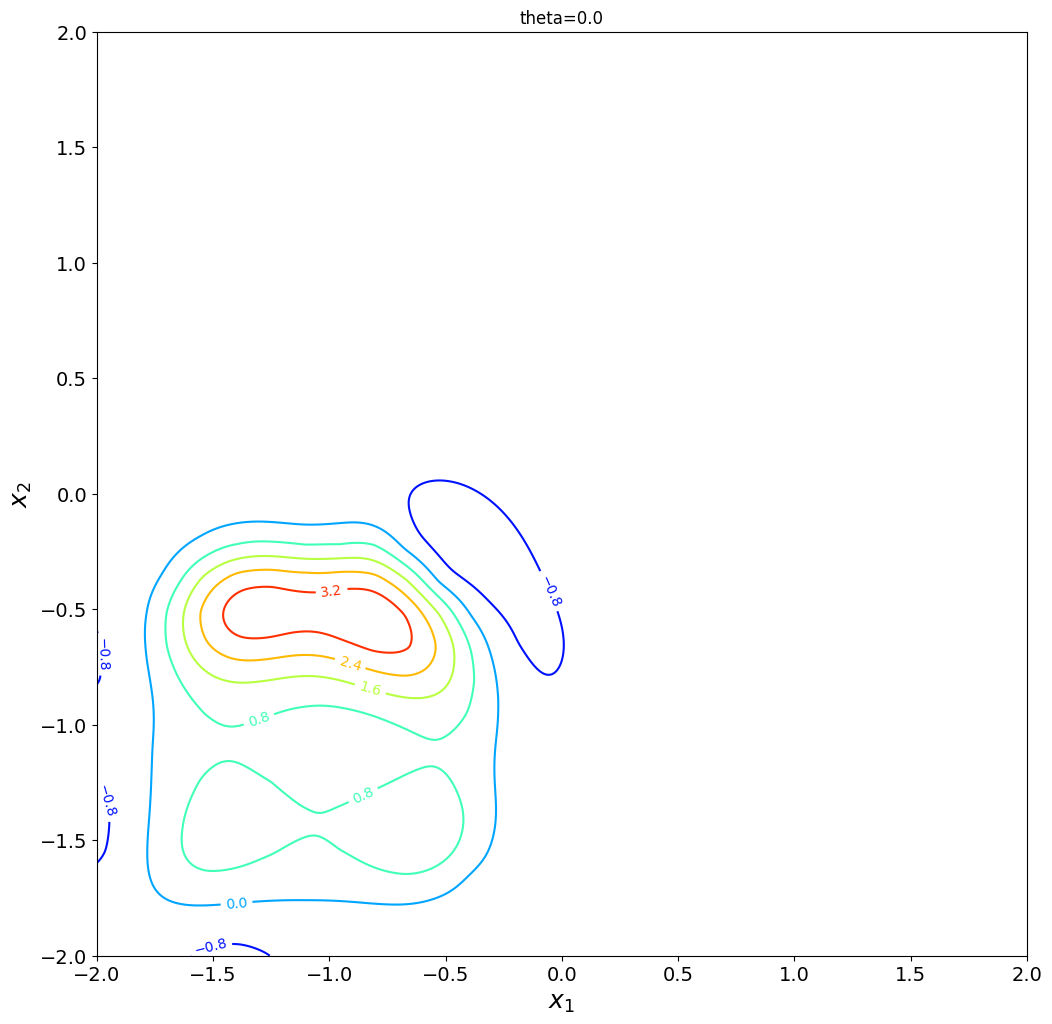

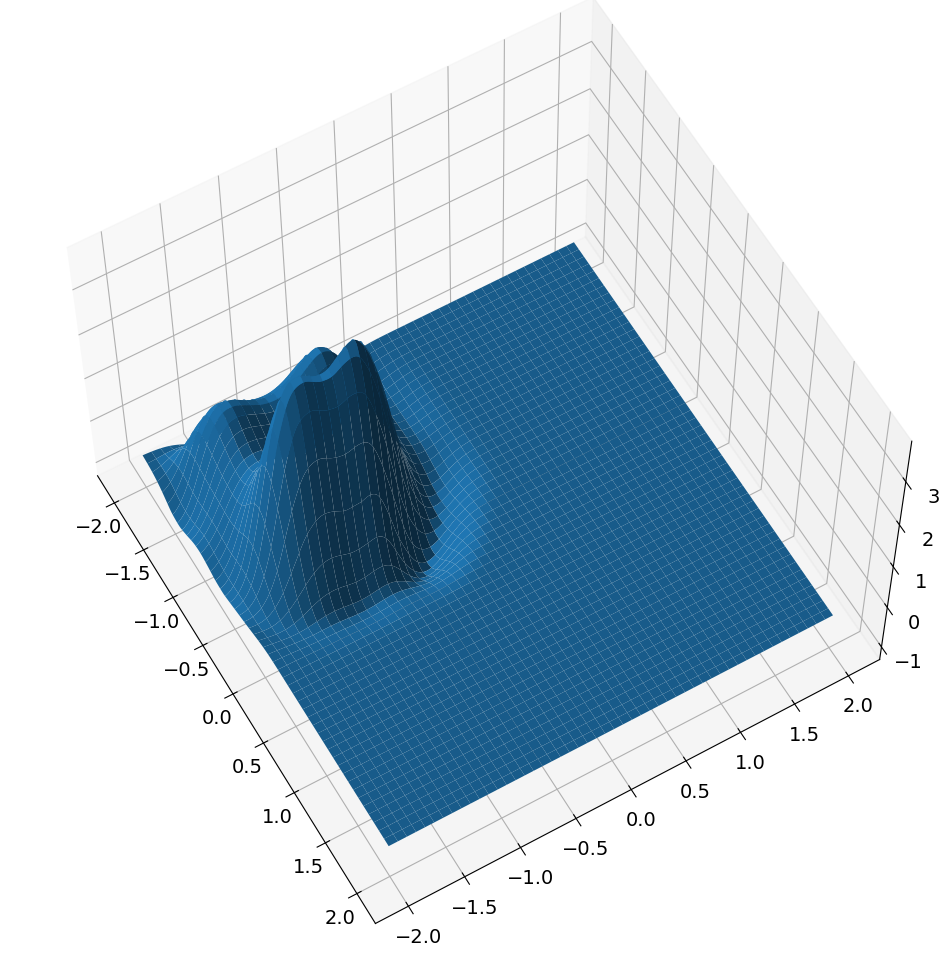

max h 3.8055951011991063


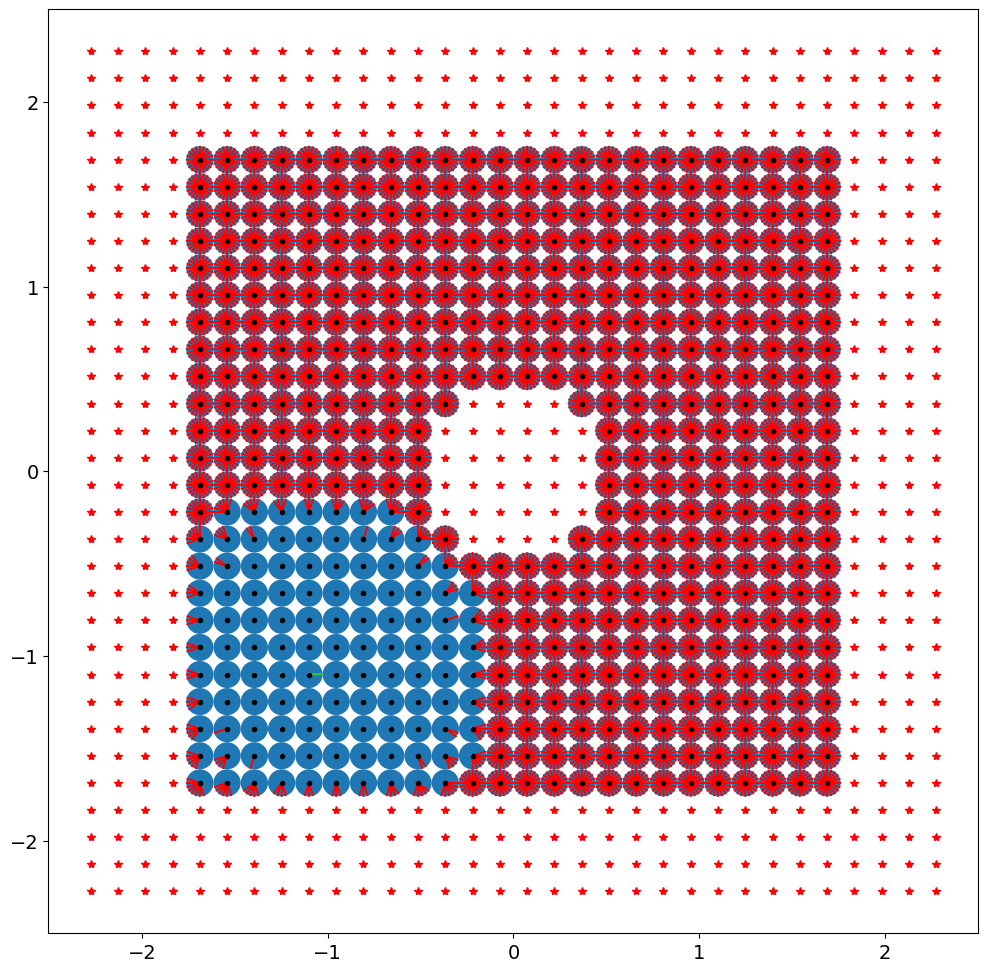

In [18]:
########################
### Plot Initial CBF ###
########################

h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1])
plot_angles(a, grid, loc_hjb_grid, obs_dict, pos=a.pos)

In [19]:
##################################
### Configure Safe Exploration ###
##################################

DT   = 0.0025
tol  = 1.15*gamma_safe #h_max/2 # h-value at which to halt approach
eps  = 0
dx   = 0.5     # if |x'-x|<dx, approach again
tend = 20      # Duration of boundary approach
T    = 0.3     # MPC horizon (default timestep is 0.05)
N    = 3       # number of CBFs to learn

target: [ 1 -1  0]
position is [-1.1 -1.1  0. ]
h is 0.5484207972164781
start time is 0


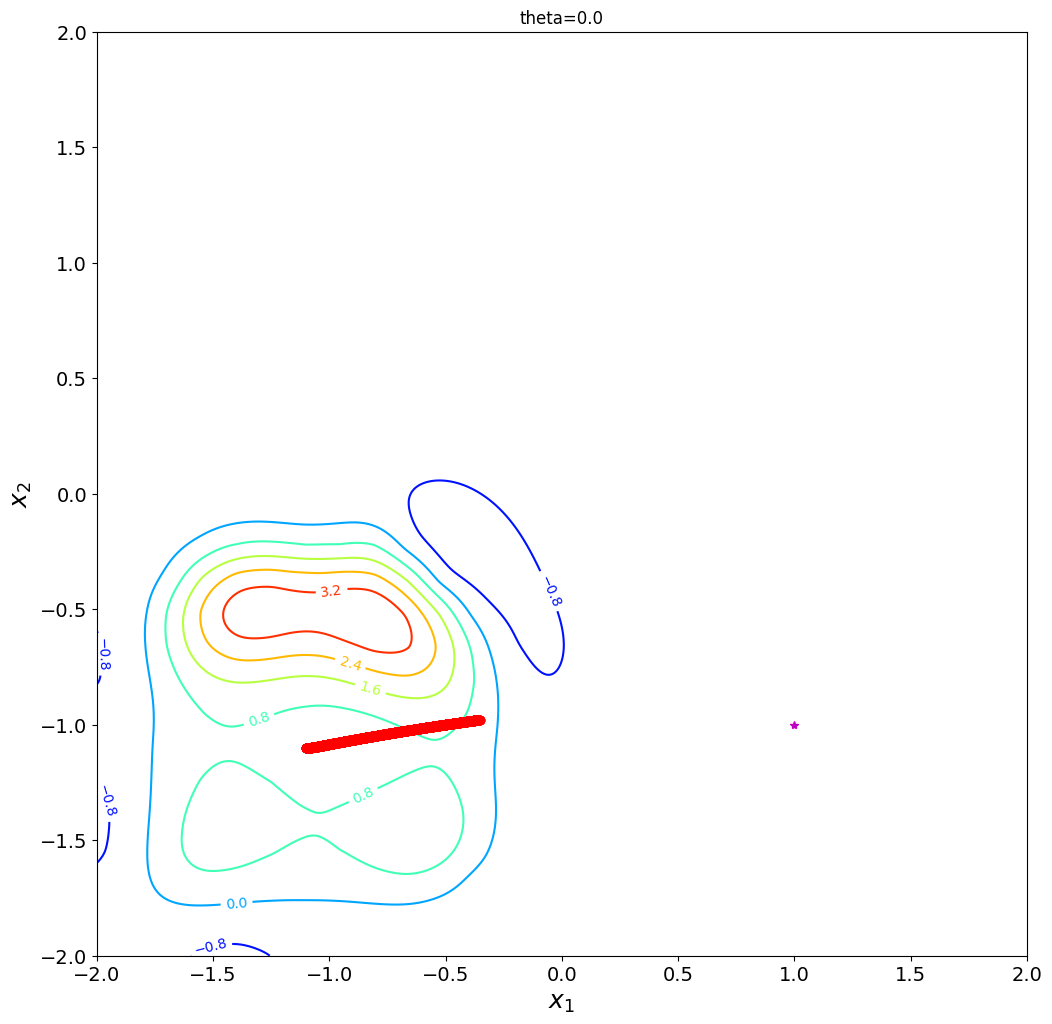

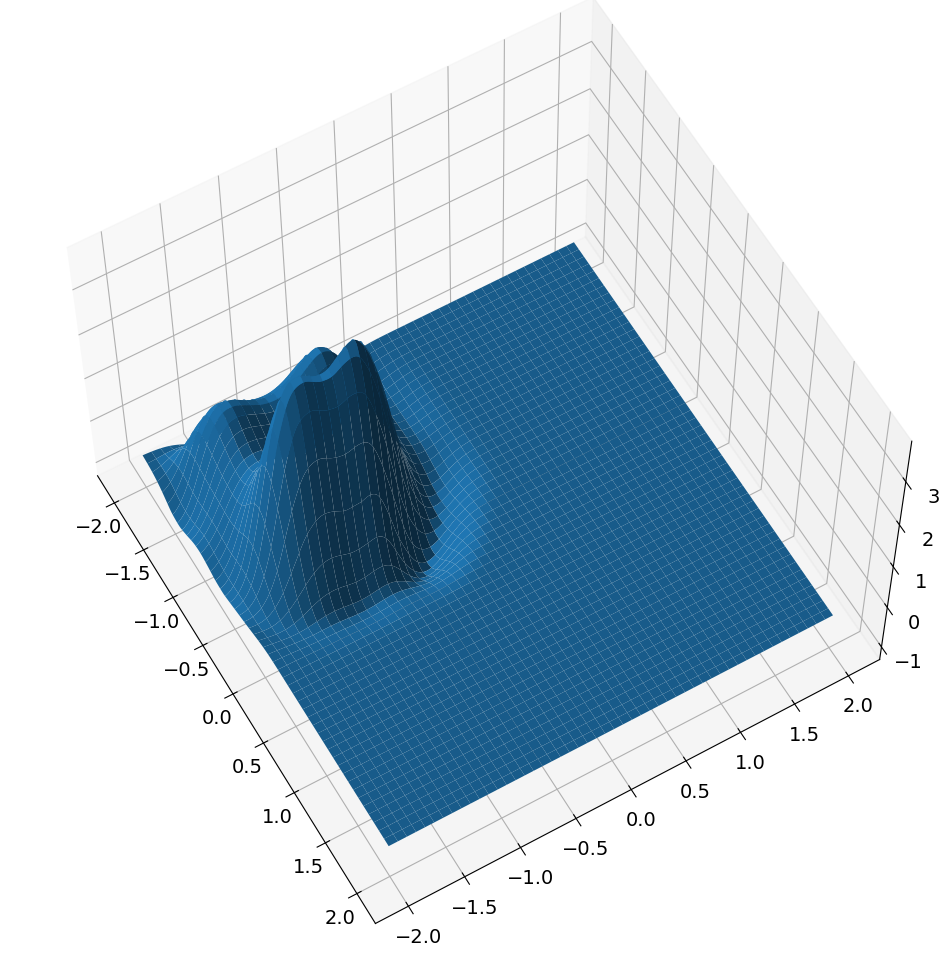

max h 3.8055951011991063
new position is [-0.35304636 -0.97868937  0.10674345]
h is now 0.34498394871698024
new time is 20
dx: 0.7642317552697075


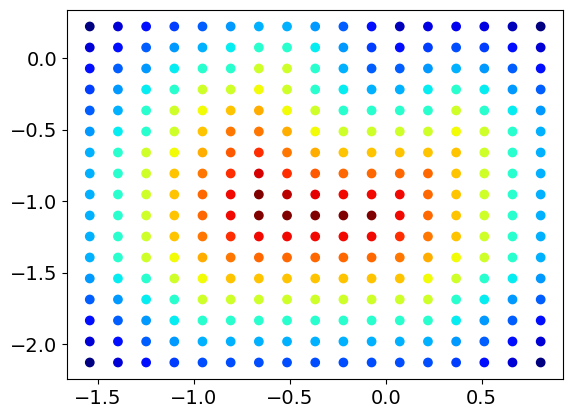

100%|############################################################################################################################################| 500.0000/500.0 [00:00<00:00, 621.99sim_s/s]


<Figure size 640x480 with 0 Axes>

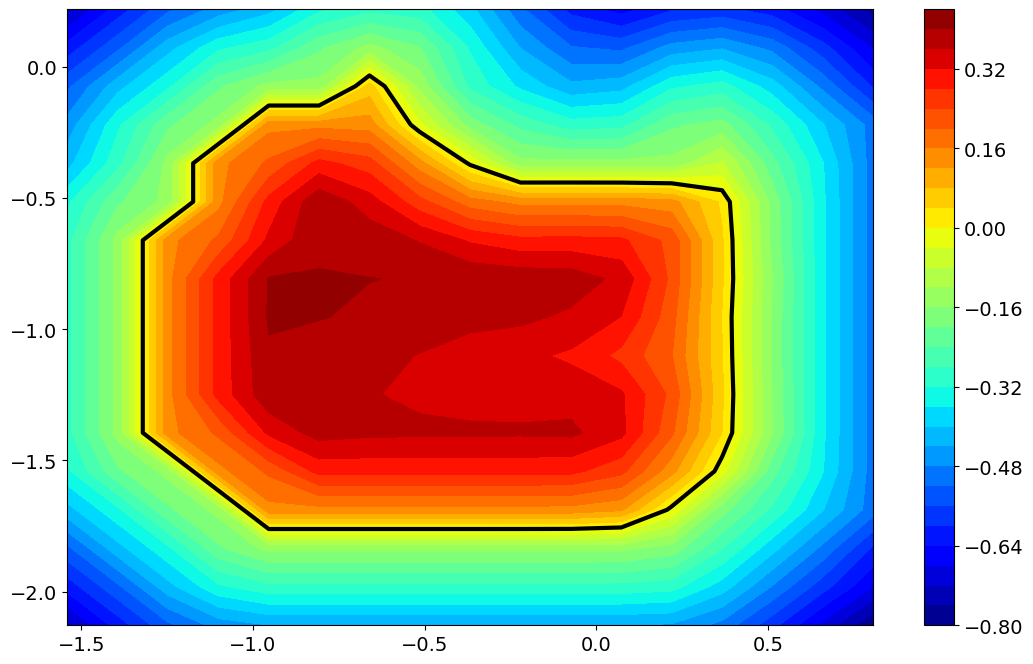

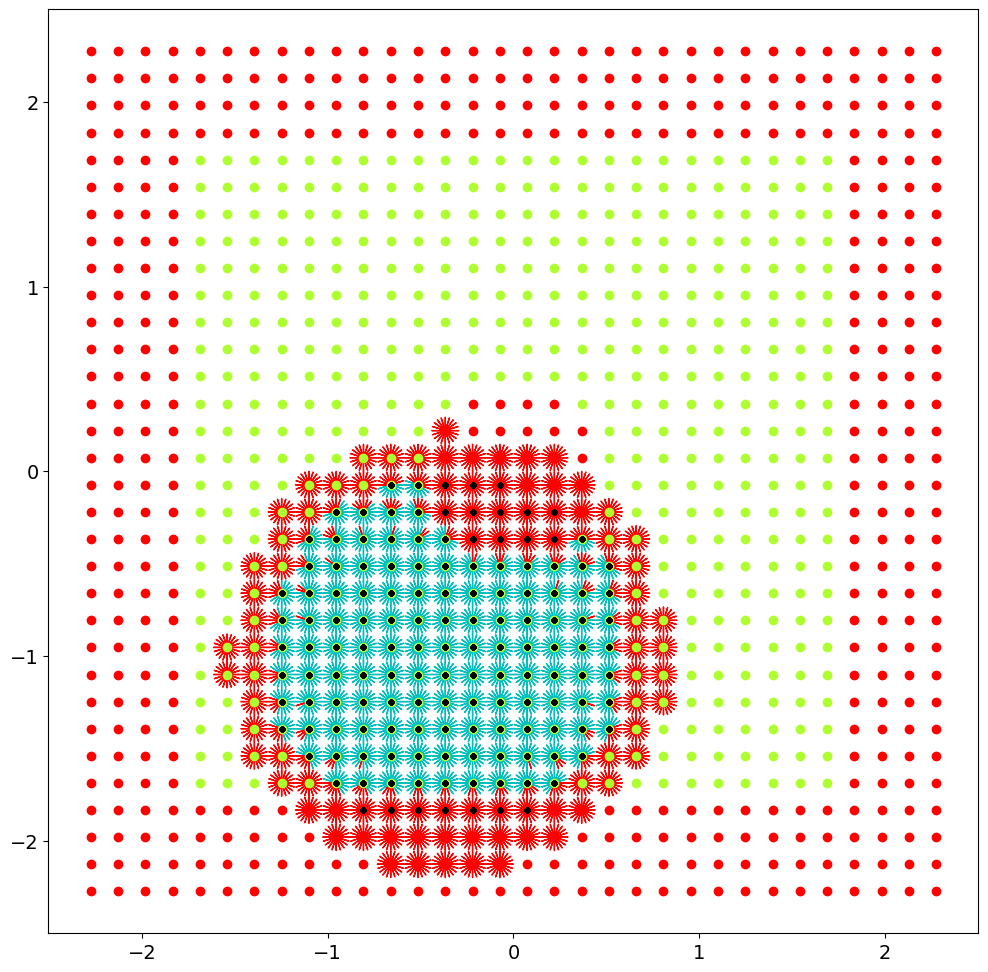

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 10 08:57:12 AM: Your problem has 2211 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 10 08:57:12 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 10 08:57:12 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 10 08:57:12 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 10 08:57:12 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 10 08:57:12 AM: Compiling problem (target solver=CLARABEL)

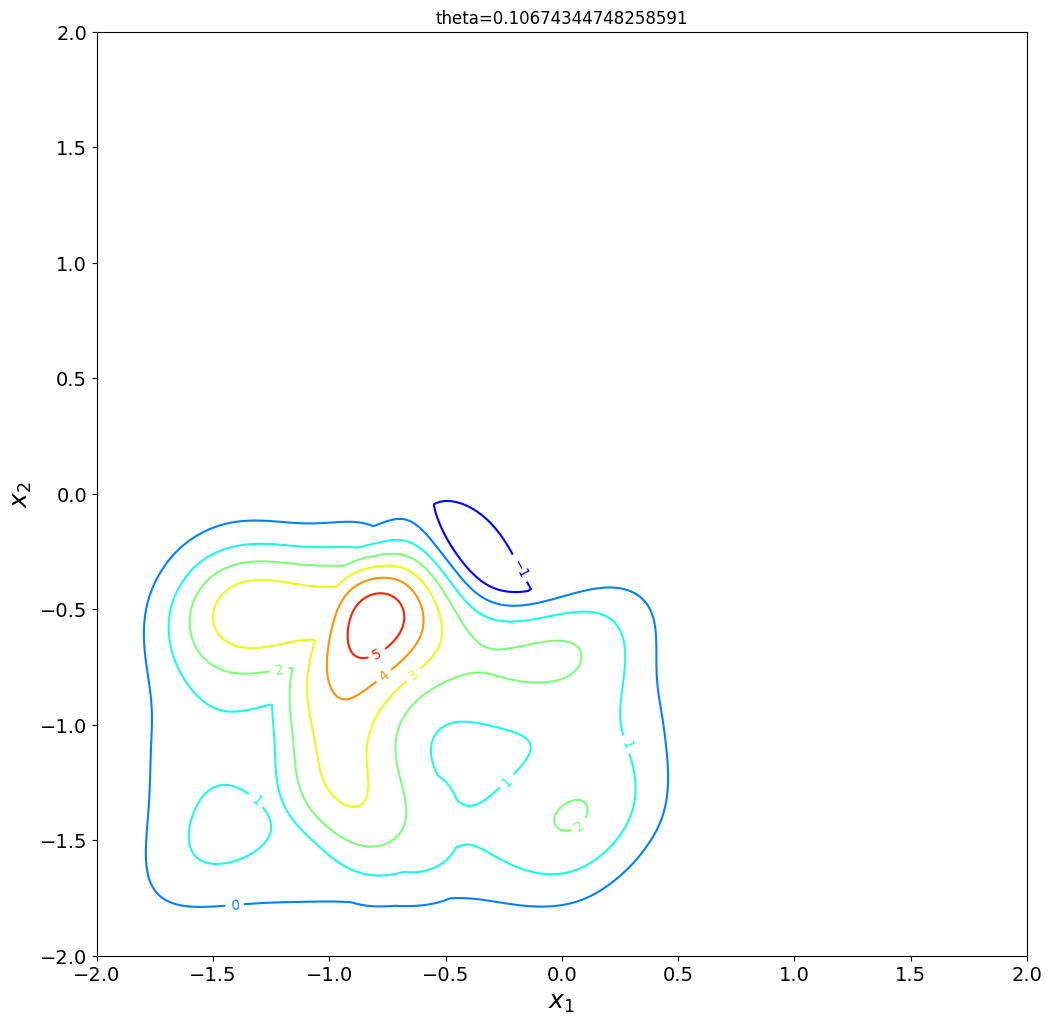

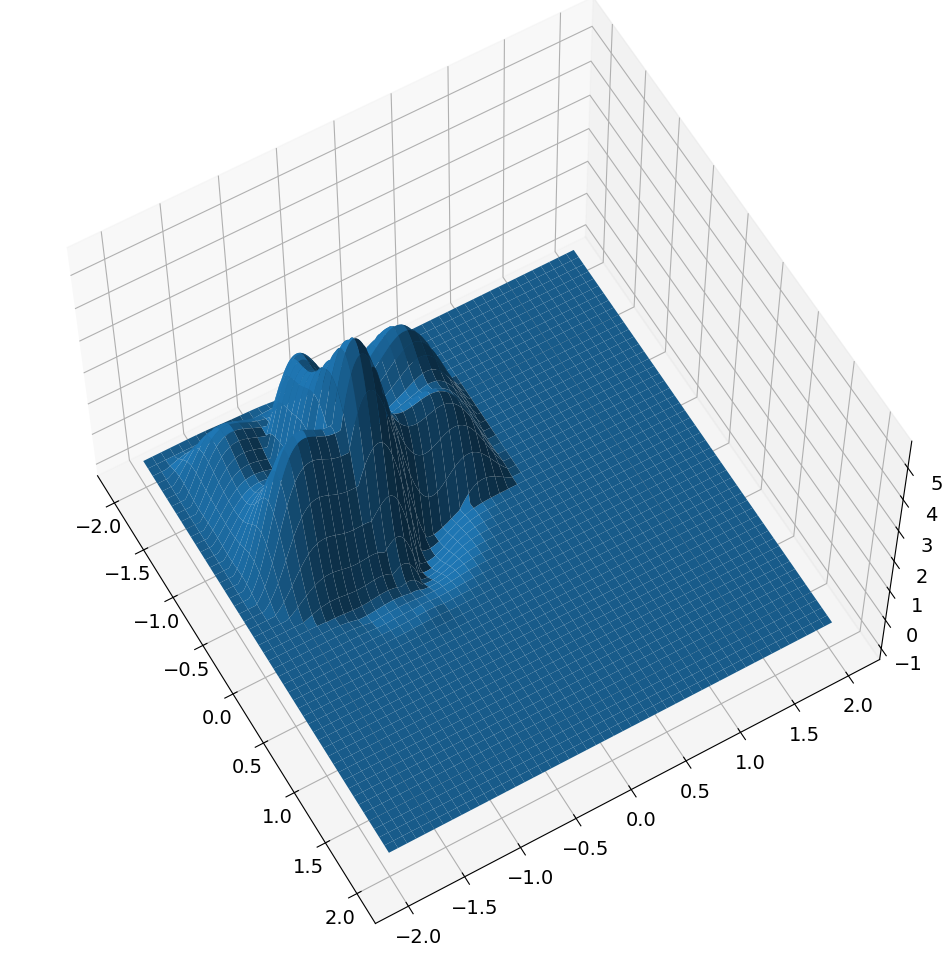

max h 5.679030523247762


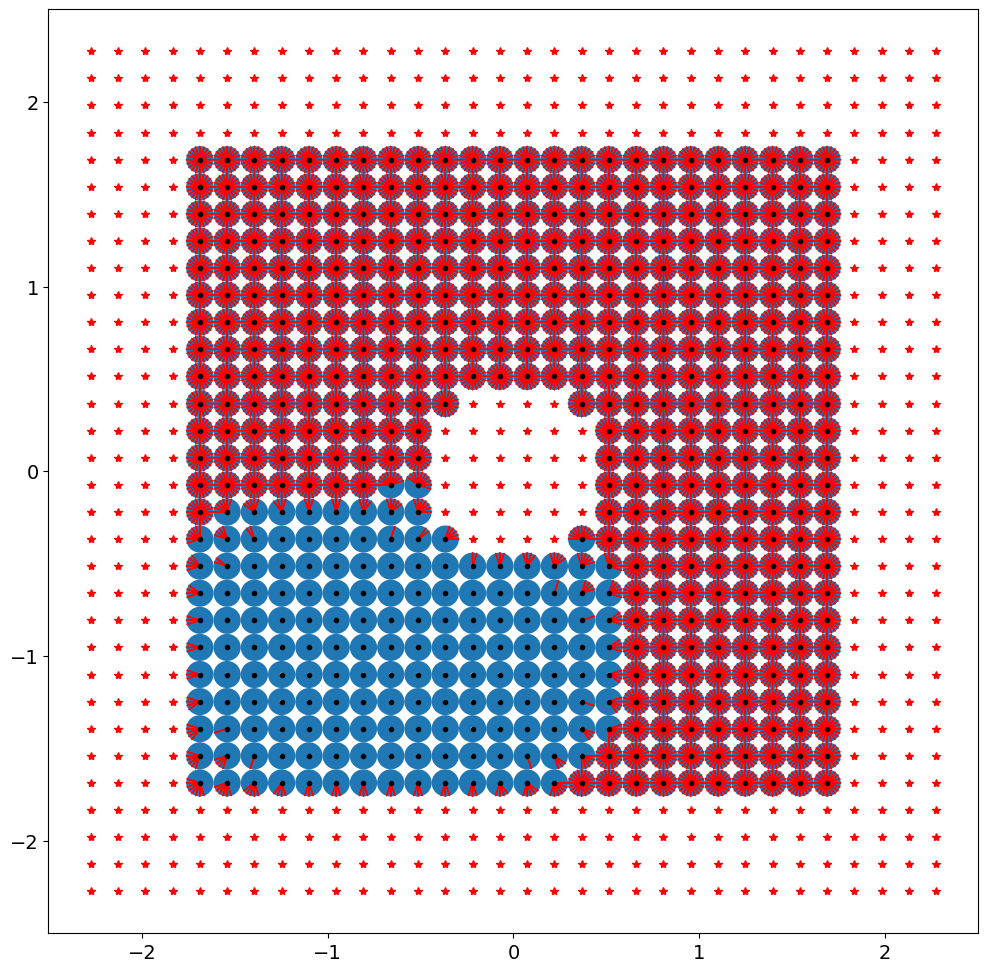

target: [ 1 -1  0]
position is [-0.35304636 -0.97868937  0.10674345]
h is 1.063505861268472
start time is 20


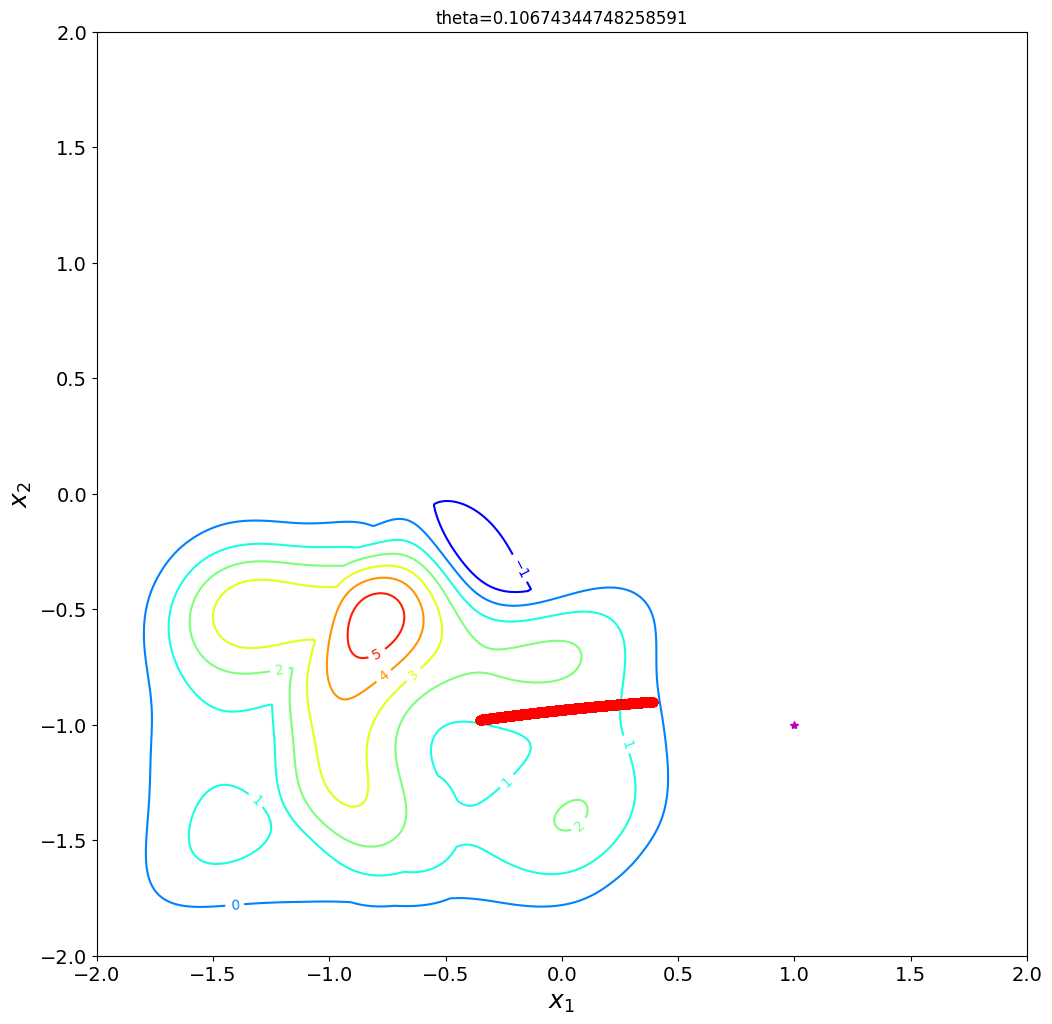

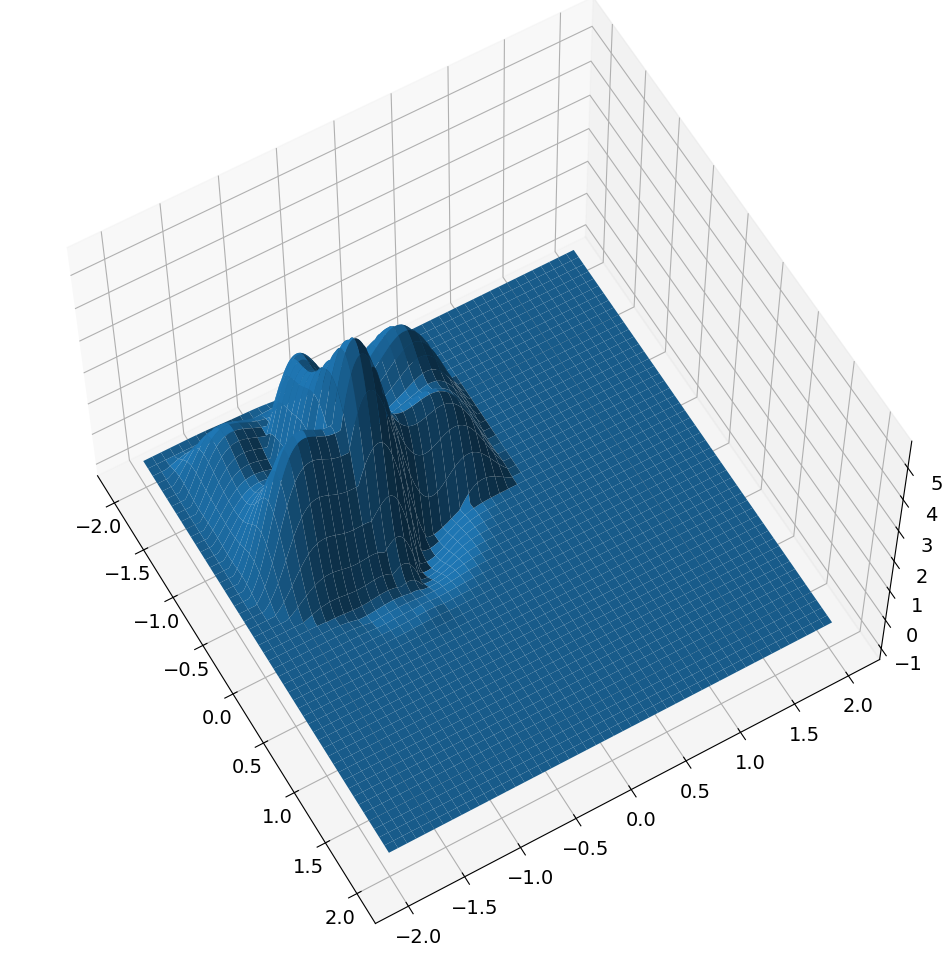

max h 5.679030523247762
new position is [ 0.39272806 -0.90054411  0.03354491]
h is now 0.3441622919603742
new time is 40
dx: 0.753421655683934


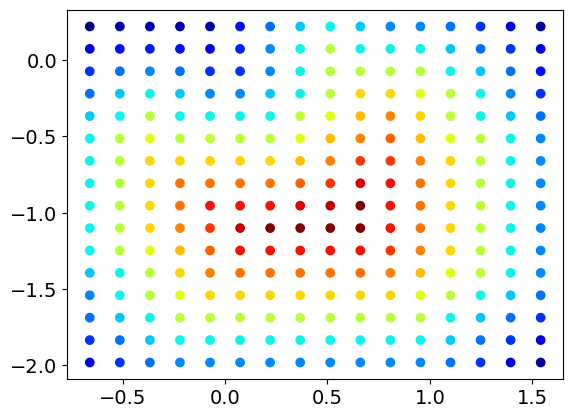

100%|############################################################################################################################################| 500.0000/500.0 [00:00<00:00, 701.94sim_s/s]


<Figure size 640x480 with 0 Axes>

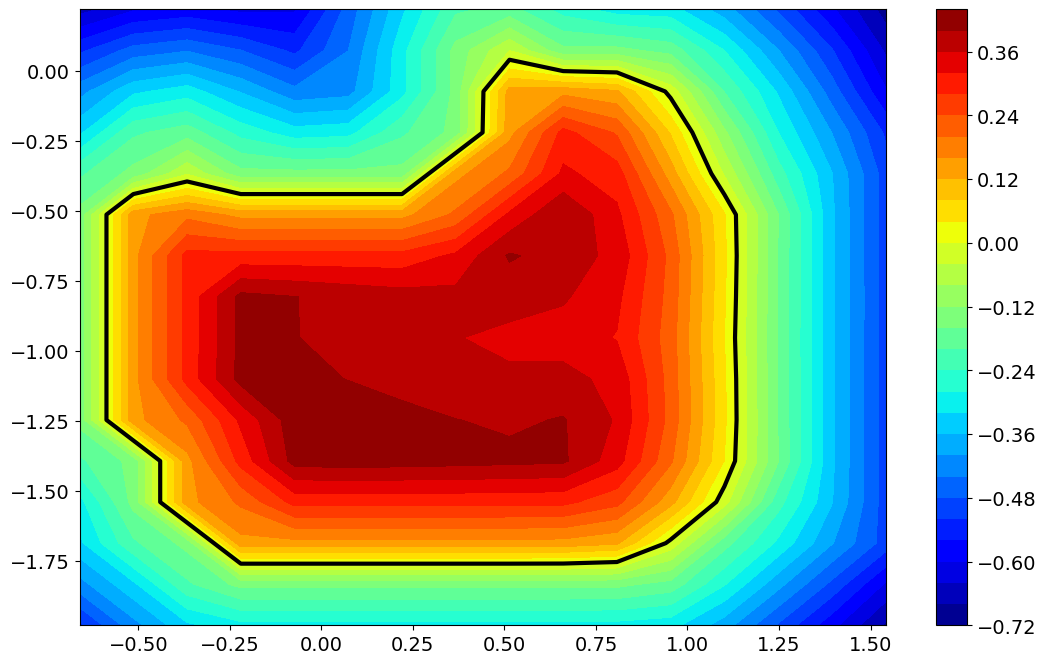

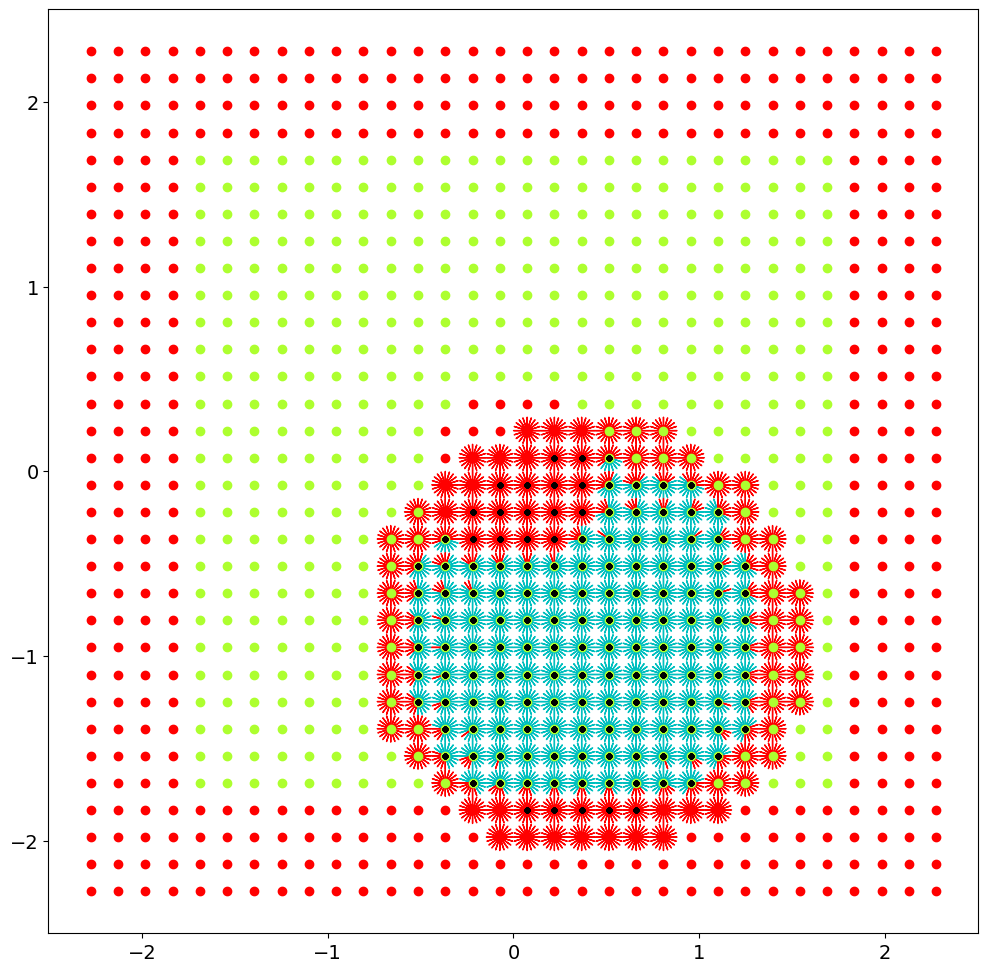

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 10 09:00:00 AM: Your problem has 2273 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 10 09:00:00 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 10 09:00:00 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 10 09:00:00 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 10 09:00:00 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 10 09:00:00 AM: Compiling problem (target solver=CLARABEL)

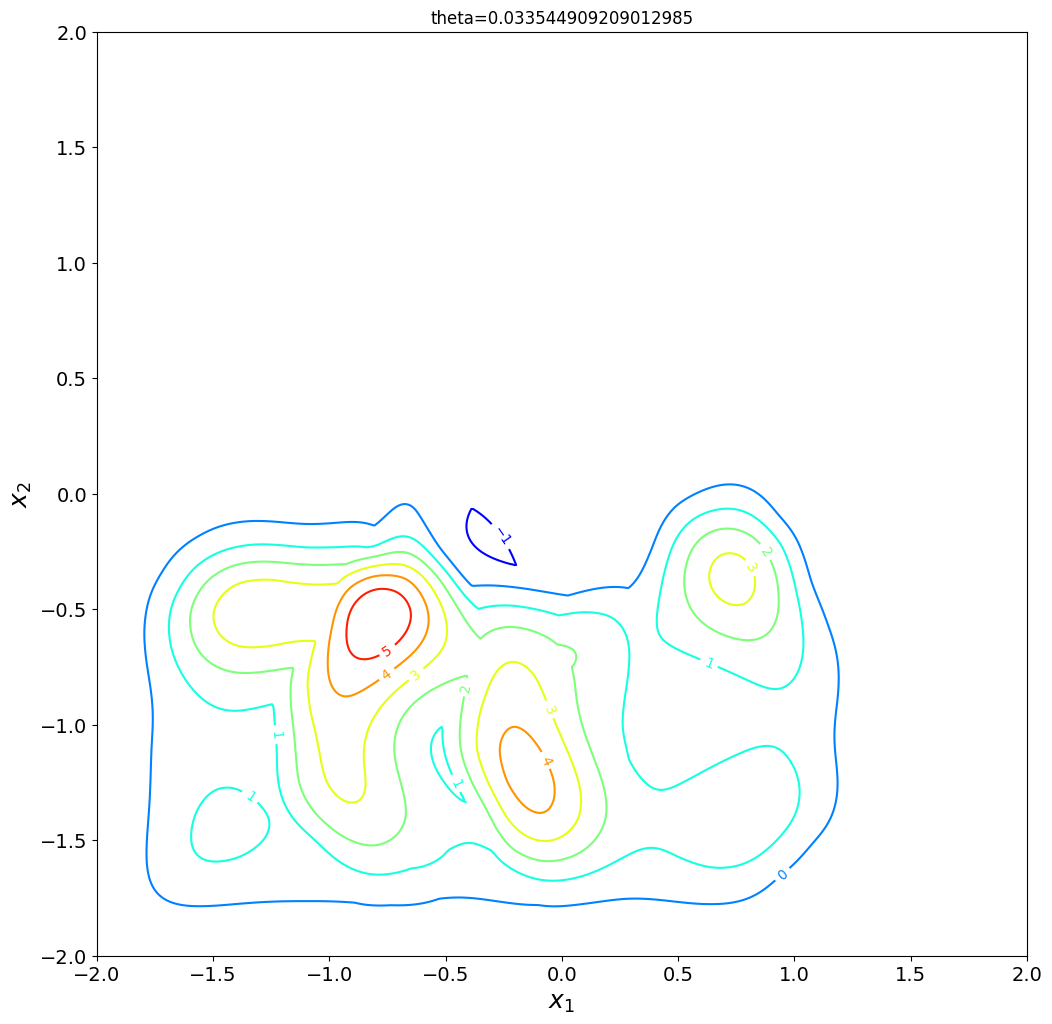

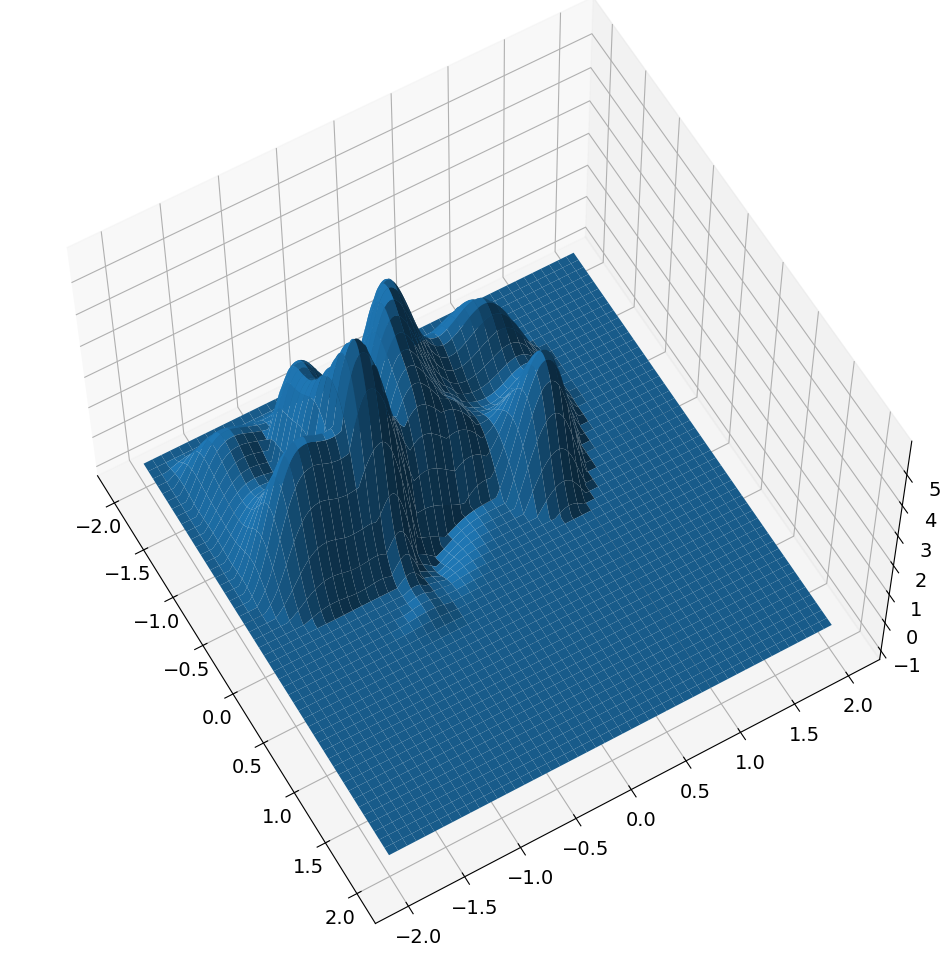

max h 5.910754881576154


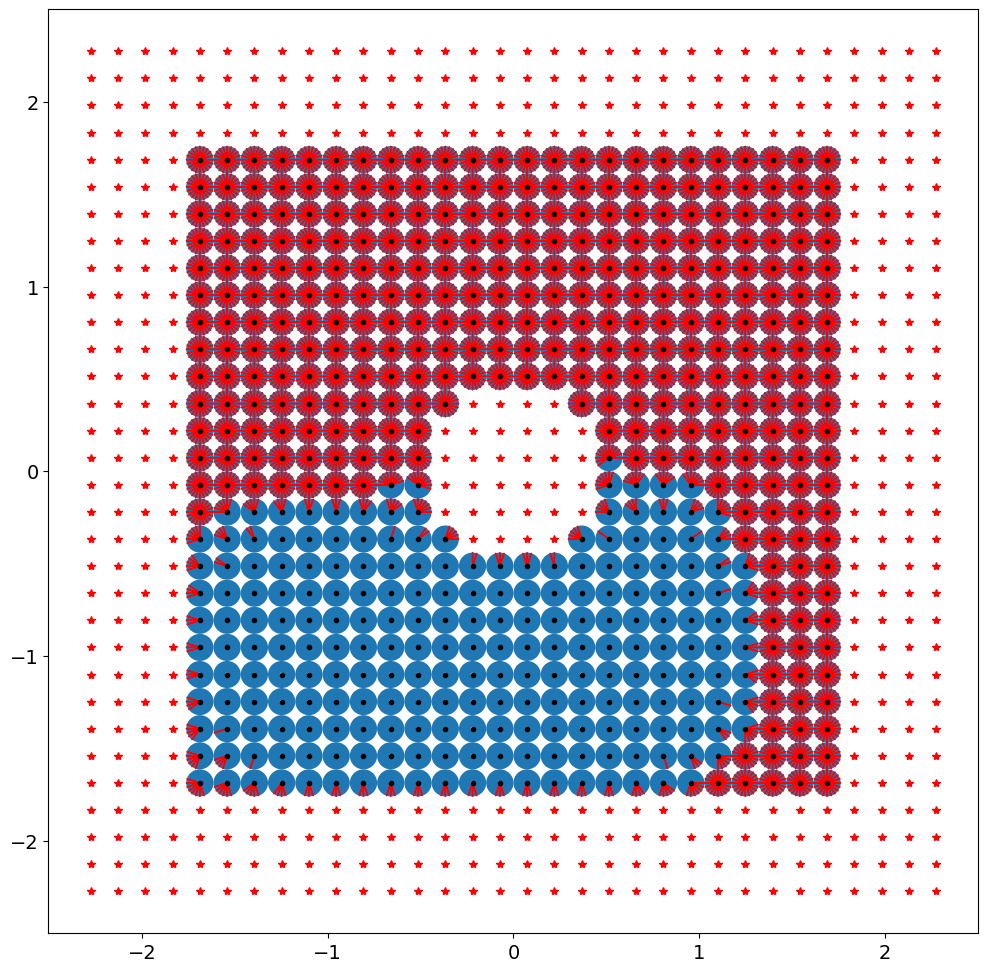

target: [1.         1.         1.57079633]
position is [ 0.39272806 -0.90054411  0.03354491]
h is 0.5568983164455983
start time is 40


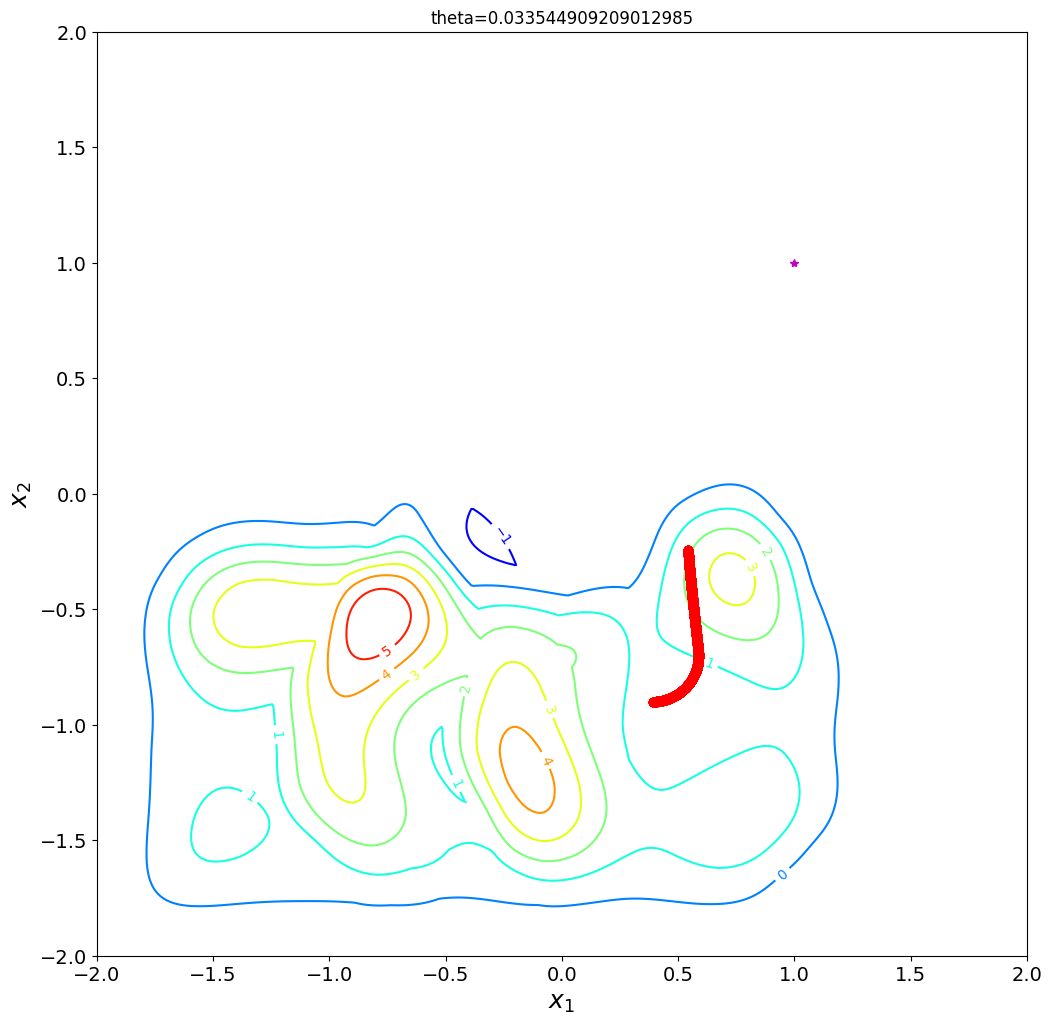

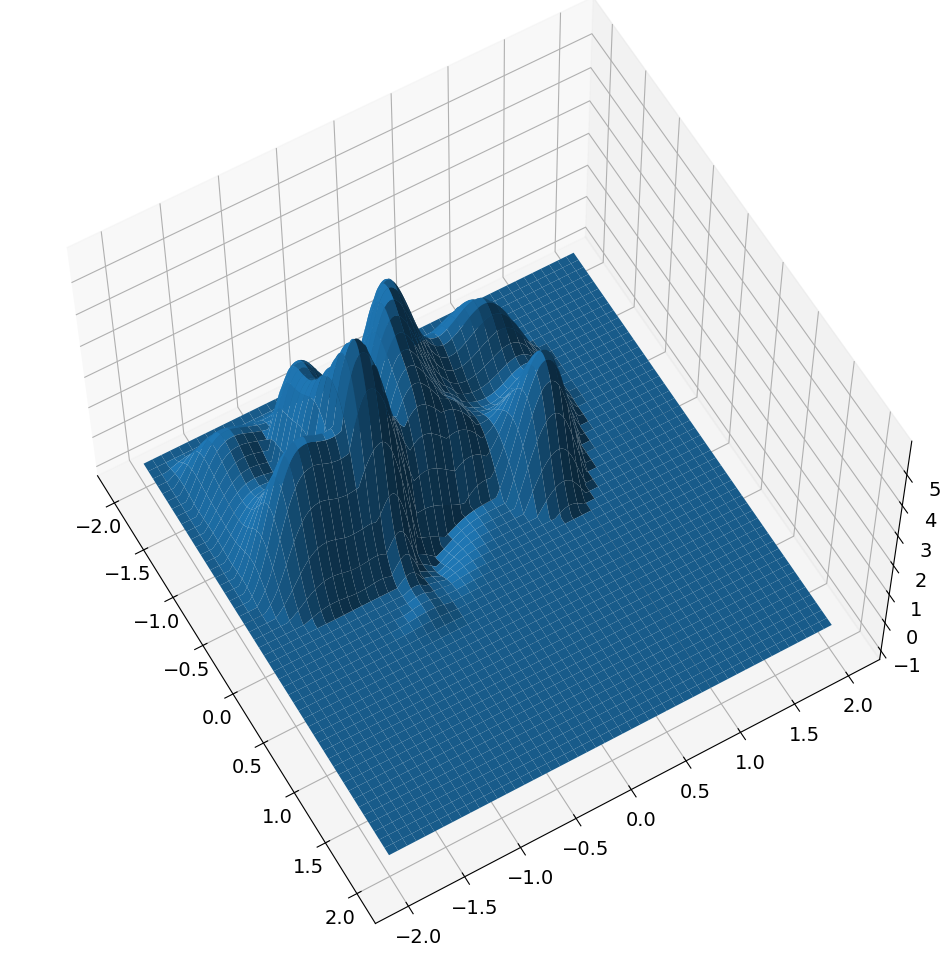

max h 5.910754881576154
new position is [ 0.54411107 -0.24219038  1.58917117]
h is now 0.3445042082343872
new time is 60
dx: 1.6959715559562634


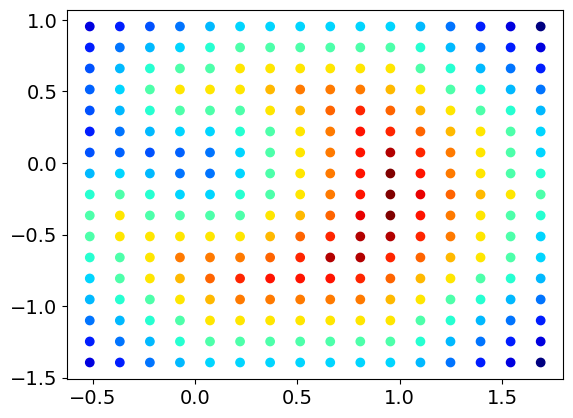

100%|############################################################################################################################################| 500.0000/500.0 [00:00<00:00, 638.88sim_s/s]


<Figure size 640x480 with 0 Axes>

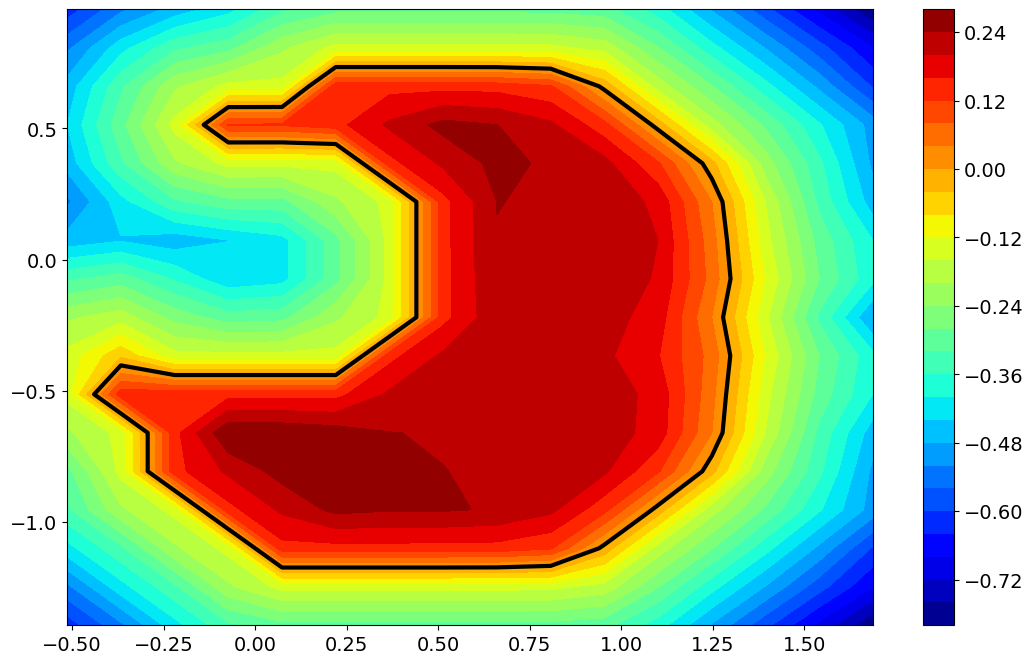

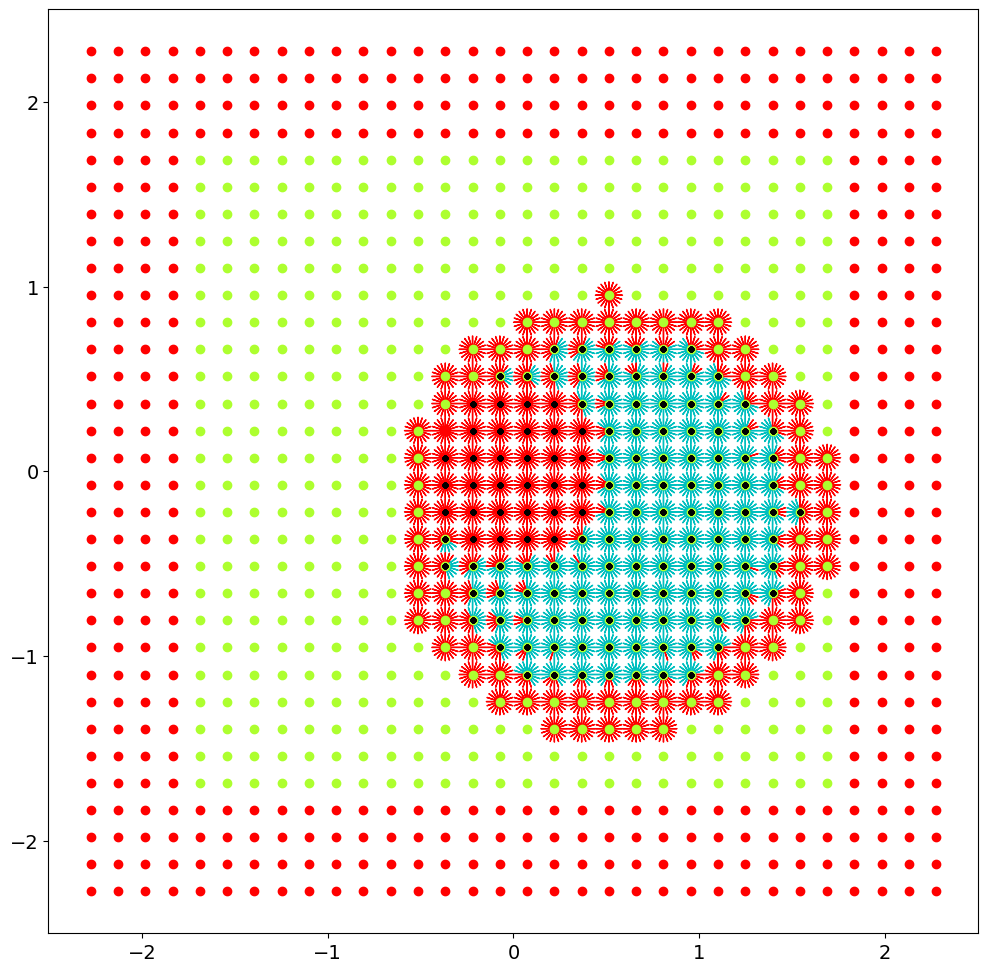

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 10 09:03:30 AM: Your problem has 1877 variables, 1 constraints, and 0 parameters.
(CVXPY) Jul 10 09:03:30 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 10 09:03:30 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 10 09:03:30 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 10 09:03:30 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 10 09:03:30 AM: Compiling problem (target solver=CLARABEL)

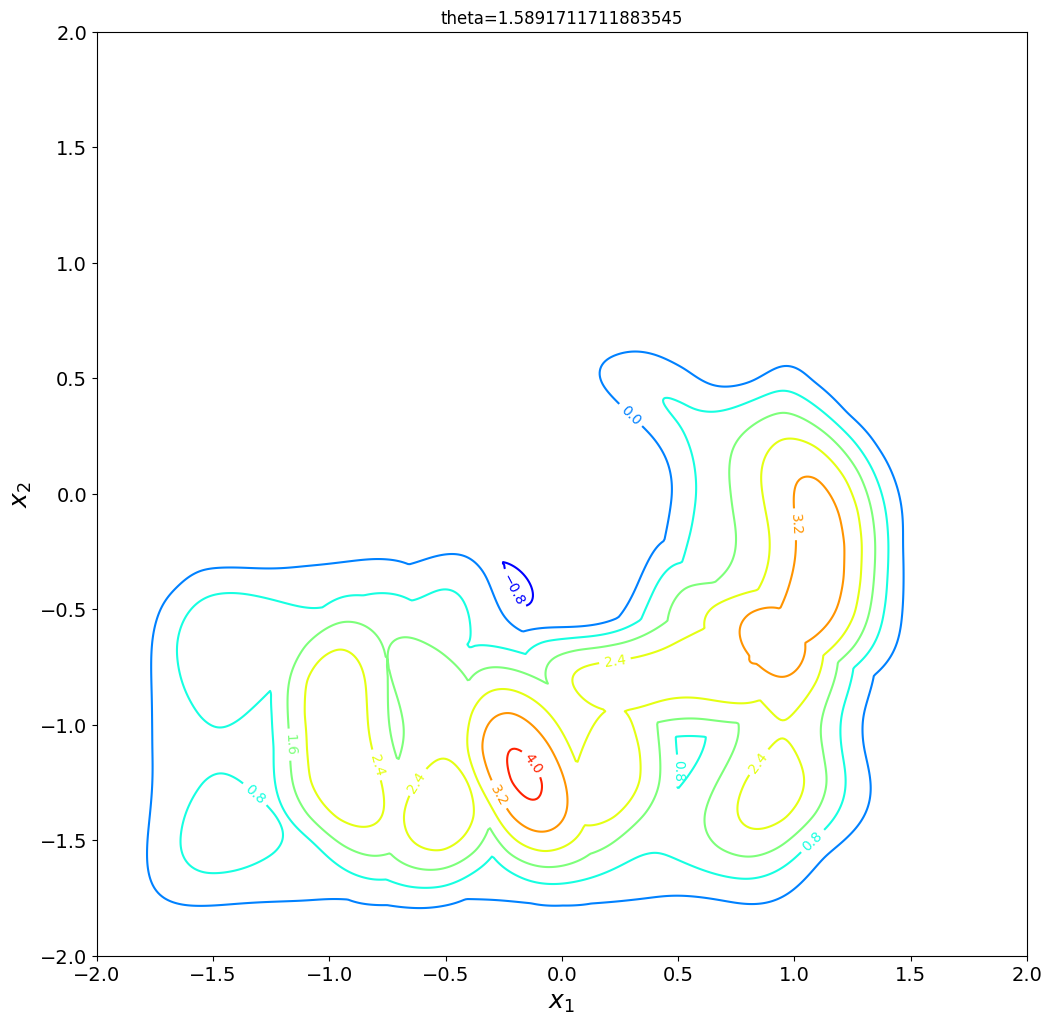

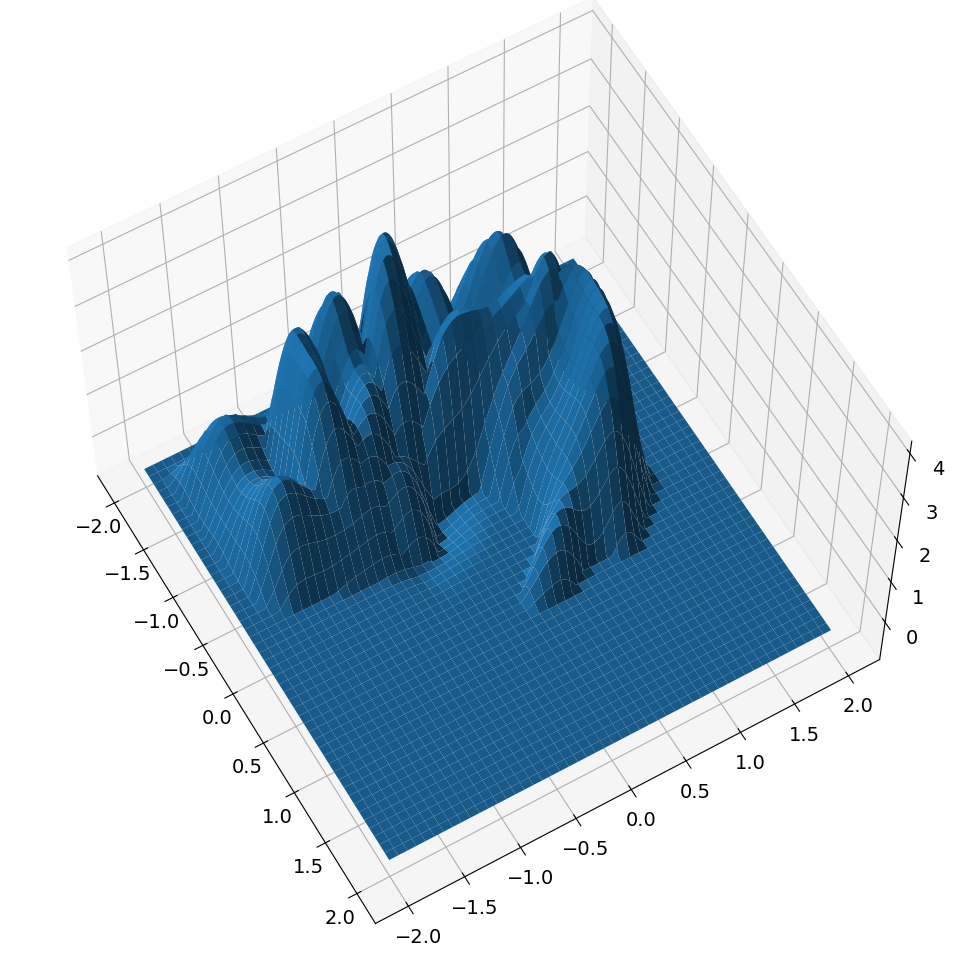

max h 4.167946358658152


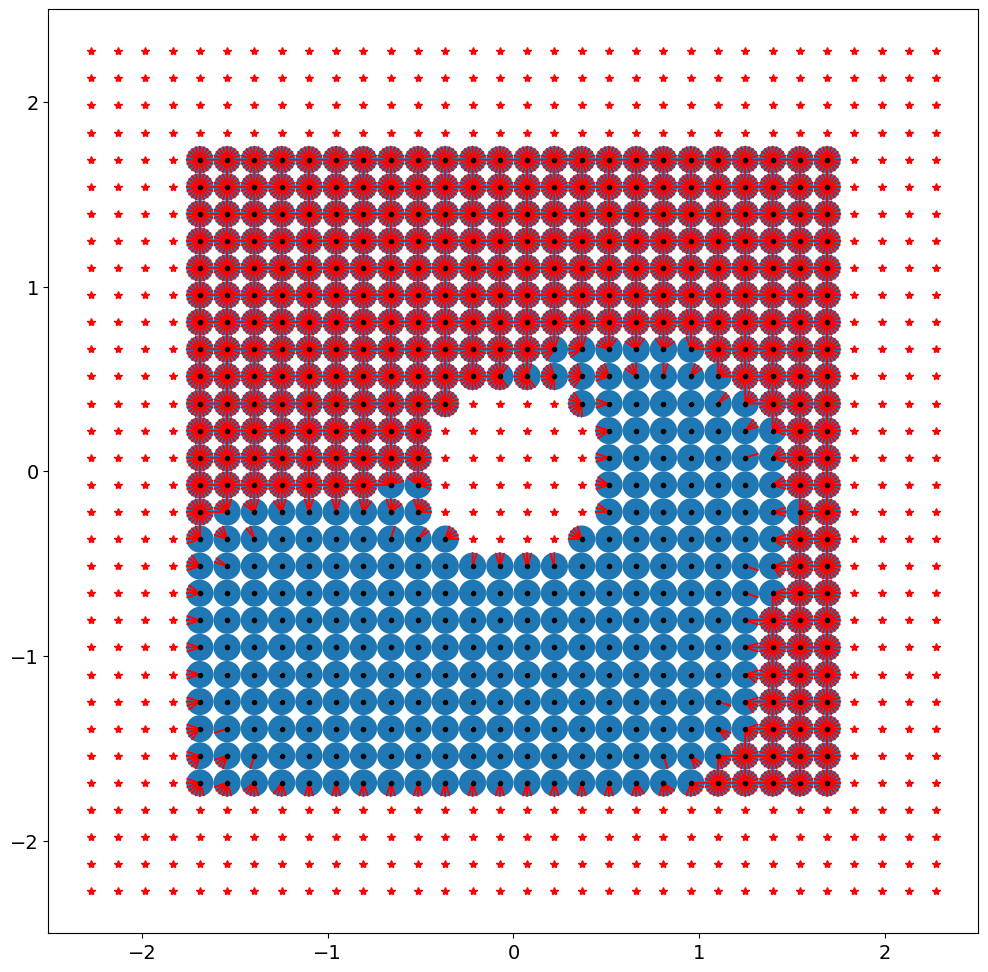

In [20]:
##########################
### Safe Exploration ###
##########################

targets   = [np.array([1, -1,       0]),
             np.array([1, -1,       0]),
             np.array([1,  1, np.pi/2]),
             np.array([1,  1, np.pi/2])]
#targets   = None

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    
    prev_pos = a.pos  
    if targets is not None:
        print("target:", targets[i]) 
        traj = a.goto(targets[i], T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps)  
        print("dx:", np.linalg.norm(a.pos - prev_pos))
    else: 
        while np.linalg.norm(a.pos - prev_pos) <= dx:    
            target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
            target_angle = np.array([2 * np.pi * np.random.rand()])
            target       = np.hstack((target_pos, target_angle)) 
            while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
                target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
                target_angle = np.array([2 * np.pi * np.random.rand()])
                target       =  np.hstack((target_pos, target_angle)) 
            print("target:", target) 
            a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1]) 
            print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################

    # scan states 
    pts_safe, pts_unsafe   = a.scan()
    #samples, gparams       = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True)
    samples, gparams,\
             is_obs_sample = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True)
    loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], pts_safe, np.vstack((pts_unsafe, samples[:,:2])), rx, thn, T=500, mult=mult)
    #loc_V, loc_hjb_grid    = a.get_local_V(gparams, pts_safe, np.vstack((pts_unsafe, samples[:,:2])), rx, thn, T=500)
    scan_safe, scan_unsafe = a.scan_hjb(loc_V, loc_hjb_grid)
    n_safe                 = len(pts_safe)
    x_buffer, x_safe       = a.make_buffer(scan_safe, int(nm * n_safe), p, hjb=True)
    
    # unsafe states 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples    
        
    # centers
    C = []
    for x in c_grid:
        if np.linalg.norm(x[:2] - a.pos[:2]) <= rc:
            C.append(x)
    C = np.array(C)    
    tmp = []
    for c in C:
        c = np.repeat(c.reshape(1, -1), hjb_grid.states.shape[2], axis=0)
        c = np.hstack((c, np.array(hjb_grid.coordinate_vectors[2]).reshape(-1, 1)))
        tmp.append(c)
    C = np.vstack(tmp)  
    a.centers.append(C)

    # plot CBF data
    plot_angle_data(C, grid, obs_dict, spacing, safe=x_safe, buffer=x_buffer, unsafe=scan_unsafe, samples=samples)

    # safe and buffer control
    u_safe = hjb_controls_parallel(a, x_safe, loc_hjb_grid, loc_V, verbose=True)
    if x_buffer.shape[0] != 0:
        u_buffer = hjb_controls_parallel(a, x_buffer, loc_hjb_grid, loc_V)
    else:
        u_buffer = np.array([])
    ''' 
    # safe and buffer controls
    u_buffer = []
    for x in tqdm(x_buffer):
        u_buffer.append(hjb_controls(a, x, loc_hjb_grid, loc_V))
    u_buffer = np.array(u_buffer)
    u_safe = []
    for x in tqdm(x_safe):
        u_safe.append(hjb_controls(a, x, loc_hjb_grid, loc_V))
    u_safe = np.array(u_safe)
    '''

    #####################
    ### Learn new CBF ###
    ##################### 
    
    #L = get_learning_cbfs_lagrangian_hj(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh, gamma_safe, gamma_dyn, gamma_unsafe)
    #theta, _, _ = scipy.optimize.fmin_l_bfgs_b(L, 10*(np.random.rand(C.shape[0], 1)-5), approx_grad=False, iprint=50) 
    #theta = cvx_train_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, lam_dh=lam_dh, lam_sp=lam_sp, verbose=True)
    theta = np.array(clarabel_solve_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe))
    a.thetas.append(theta)
    a.rectify_c_and_theta()

    # plot new CBF
    h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1])
    plot_angles(a, grid, hjb_grid, obs_dict)

    # collect quad plot data
    curr_data    = np.copy(np.vstack( ( curr_data, np.vstack((x_safe, x_buffer, x_unsafe)) ) ))
    curr_centers = np.copy(np.array(a.centers))
    curr_thetas  = np.copy(np.array(a.thetas))
    curr_traj    = np.copy(np.vstack( (curr_traj, traj) ))
    quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)
    quad_plot_args.append((i+1, curr_centers, curr_thetas, curr_data))

final_pos = np.copy(a.pos)
quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)

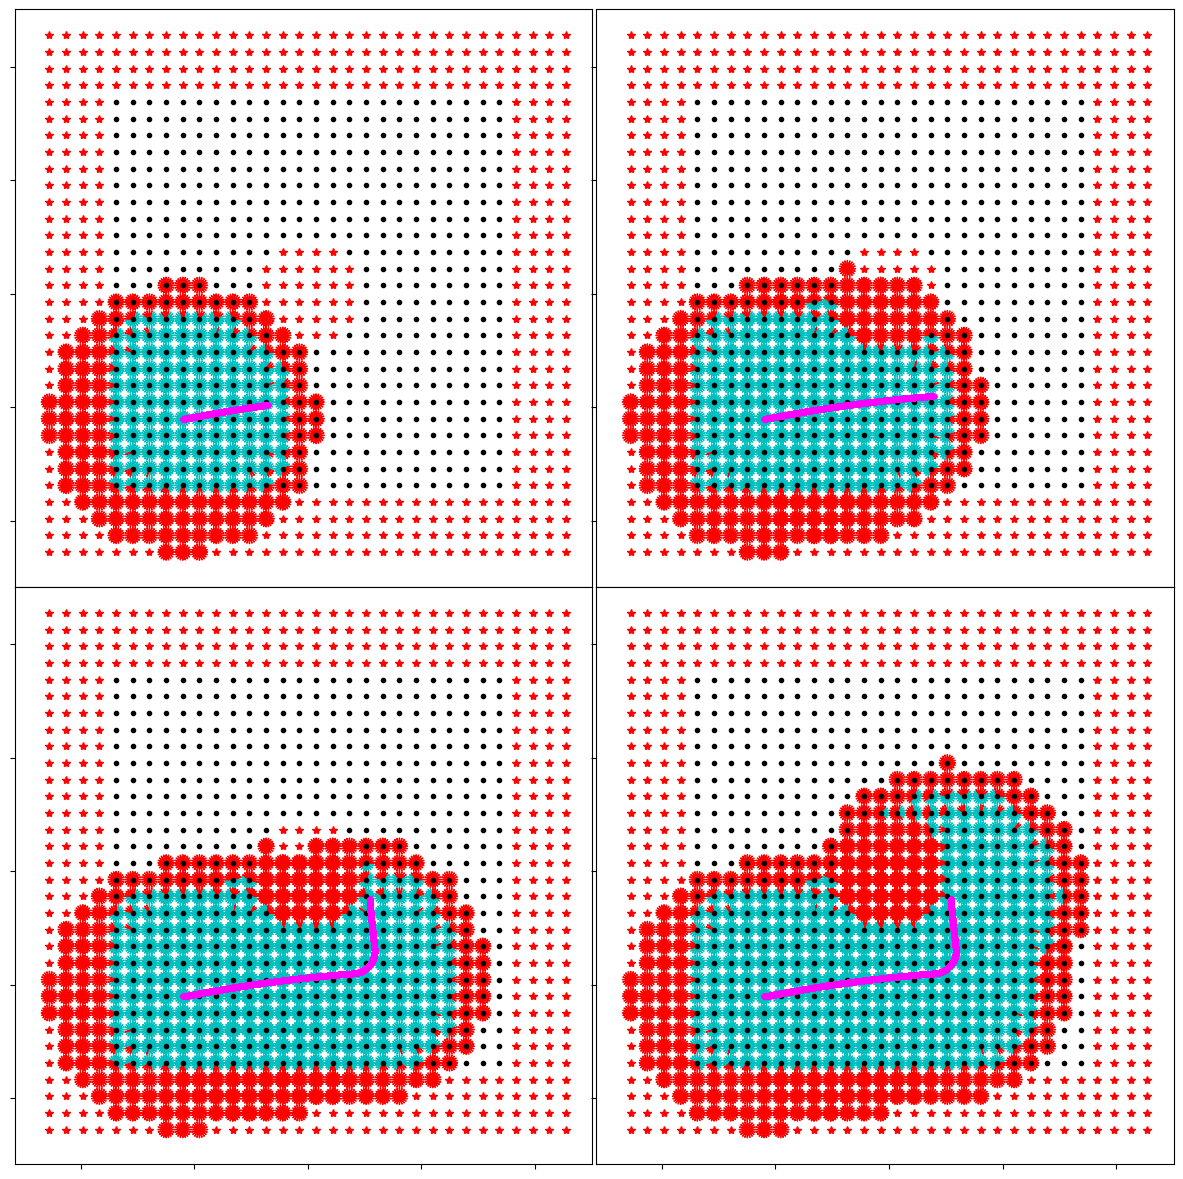

In [21]:
fig = plt.figure(figsize=(15, 15))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal') 
    
fig.subplots_adjust(wspace=0, hspace=0)

for i, args in enumerate(quad_plot_args):
    #print(args[1].shape)
    #print(args[2].shape)
    #print(args[3].shape)
    quad_plot(a, axs[i], args[0], args[1], args[2], args[3], args[4], grid, obs_dict)
plt.show()